In [1]:
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from random import sample
import csv
from func import *

# Load county information

In [2]:
path = 'data/facebook-counties/'

In [3]:
populations = []
state = []
with open(path+'facebook-county-friendship-metadata.csv', newline='') as csvfile:
    meta_data = csv.reader(csvfile, delimiter='\t', quotechar='|')
    for row in meta_data:
        populations.append(int(row[0]))
        state.append(row[2])

labels = []
with open(path+'facebook-county-friendship.labels', newline='') as csvfile:
    meta_data = csv.reader(csvfile, delimiter='\t', quotechar='|')
    for row in meta_data:
        labels.append(row[0])
        
fips = []
with open(path+'county-info.csv', newline='') as csvfile:
    meta_data = csv.reader(csvfile, delimiter=',', quotechar='|')
    next(meta_data)
    for row in meta_data:
        fips.append(row[0])
        
xy = np.loadtxt('data/facebook-counties/facebook-county-friendship.xy')

# Read graph
#### We are going to remove the following nodes:
- counties in Hawaii and Alaska
- six disconnected counties in Virginia
- irregular node representing Loving, Texas

In [4]:
G = nx.read_graphml('data/facebook-counties/facebook-county.graphml', node_type=int)

removed = []
disconnected = ["Covington, VA", "Emporia, VA", "Fairfax, VA", 
                "Lexington, VA", "Manassas Park, VA", "Martinsville, VA"]
irregular = ["Loving, TX"]
for i in range(G.number_of_nodes()):
    if state[i] == 'HI' or state[i] == 'AK':
        removed.append(i+1)
    elif labels[i] in disconnected:
        print(labels[i])
        removed.append(i+1)
    elif labels[i] in irregular:
        print(labels[i])
        removed.append(i+1)
        
G.remove_nodes_from(removed)

Loving, TX
Fairfax, VA
Covington, VA
Emporia, VA
Fairfax, VA
Lexington, VA
Manassas Park, VA
Martinsville, VA


#### Relabel nodes from 1 to n

In [5]:
n = G.number_of_nodes()
mapping = dict(zip(G, range(1, n+1)))
G = nx.relabel_nodes(G, mapping)
map_to_original = dict((val,key-1) for key,val in mapping.items())

#### Remove edges that are longer than 500 miles

In [6]:
from geopy.distance import distance

In [7]:
ct = 0
for u,v in G.edges():
    if distance(xy[map_to_original[u]][::-1], xy[map_to_original[v]][::-1]).miles > 500:
        G.remove_edge(u,v)
        ct += 1

print(f'Number of edges removed: {ct}')
print(f'Number of edges in total: {G.number_of_edges()}')

Number of edges removed: 192
Number of edges in total: 22138


#### Plot the graph

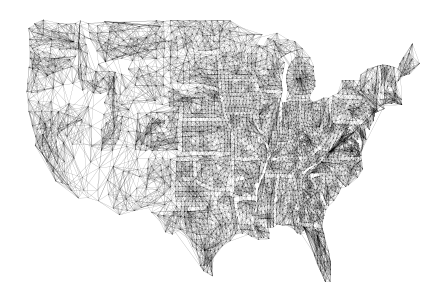

In [8]:
pos = dict((i, xy[map_to_original[i],:]) for i in range(1,n+1))
nx.draw(G, pos, node_size=0, width=.1, alpha=1)
plt.savefig("facebook.png", bbox_inches='tight', format='png', dpi=400)

# Compute betweenness measures

In [9]:
shortest_path_betweenness = nx.edge_betweenness_centrality(G)

In [10]:
current_flow_betweenness = nx.edge_current_flow_betweenness_centrality(G)

In [11]:
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

In [12]:
from julia.api import Julia
jl = Julia(compiled_modules=False)
from julia import Main

In [13]:
Main.include("local_flow_betweenness.jl");

In [14]:
local10_betweenness, _ = Main.local_flow_betweenness(np.array(G.nodes()), list(G.edges()), locality_index=.1)
local02_betweenness, _ = Main.local_flow_betweenness(np.array(G.nodes()), list(G.edges()), locality_index=.02)

# Intervention and simulation results

In [15]:
Main.include("utils.jl");
Main.include("networkSEIR.jl");

In [16]:
total_population = 0
for i in G.nodes():
    total_population += populations[map_to_original[i]]

initial_states = ['NH', 'ME', 'MA', 'CT', 'VT', 'RI']
initial_cluster = []
for i in G.nodes():
    if state[map_to_original[i]] in initial_states:
        initial_cluster.append(i)

In [17]:
A = (nx.adjacency_matrix(G) + sp.sparse.eye(G.number_of_nodes())).tocsc()

## Scenario 1: $R_0 = 2.5$

#### Verify that $\beta$ is set appropriately

In [19]:
# initial conditions
S_0 = np.zeros(n)
E_0 = np.zeros(n)
I_0 = np.zeros(n)
R_0 = np.zeros(n)
for i in range(n):
    S_0[i] = populations[map_to_original[i+1]] 
    
# the following lines set up random initializatiom
"""
for i in sample(range(n),31):
    E_0[i] = 0
    I_0[i] = populations[map_to_original[i+1]] * .001
    S_0[i] = S_0[i] - E_0[i] - I_0[i]
"""
    
# the following lines set up Chicago initialization
for i in range(n):
    county_no = map_to_original[i+1]
    if labels[county_no] =='Cook, IL':
        E_0[i] = 0
        I_0[i] = populations[county_no] * .001
        S_0[i] = S_0[i] - E_0[i] - I_0[i]
    
ini_cond = np.column_stack((S_0,E_0,I_0,R_0))

# time span
t_end = 400.
t_span = (0.,t_end)

sol = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond, t_span, R_0=2.5, phi=.071)
print(f'This should be around 0.89: {get_total_active_cases(sol)/total_population:.6f}')

This should be around 0.89: 0.891609


### Sample epidemic curves

In [33]:
perc = .25
reduced_weight = .1

In [34]:
A_ui = ((1-(1-reduced_weight)*perc)*nx.adjacency_matrix(G) + sp.sparse.eye(G.number_of_nodes())).tocsc()
A_hd = create_weighted_adjacency_from_degree_dist(G, perc, weight=reduced_weight)
A_eg = create_weighted_adjacency_from_node_betweenness(G, eigenvector_centrality, perc, weight=reduced_weight)
A_sp = create_weighted_adjacency_from_edge_betweenness(G, shortest_path_betweenness, perc, weight=reduced_weight)
A_rw = create_weighted_adjacency_from_edge_betweenness(G, current_flow_betweenness, perc, weight=reduced_weight)
A_lf10 = create_weighted_adjacency_from_edge_betweenness(G, local10_betweenness, perc, weight=reduced_weight)
A_lf02 = create_weighted_adjacency_from_edge_betweenness(G, local02_betweenness, perc, weight=reduced_weight)

#### Predicted epidemic curve: $R_0 = 2.5$, random initialization, no delay, 25% intervention

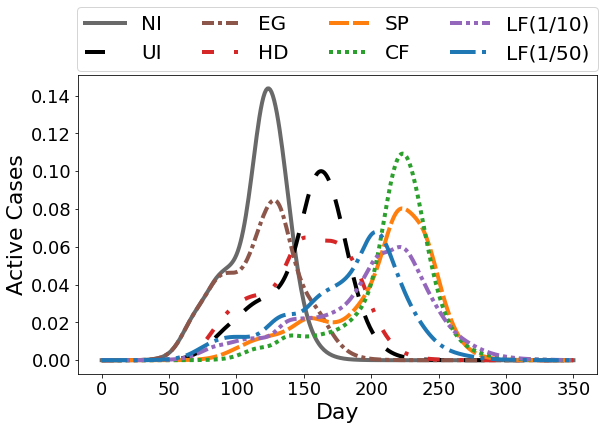

In [35]:
# time span
t_end = 350.
t_span = (0., t_end)

# initial conditions
n = G.number_of_nodes()
S_0 = np.zeros(n)
E_0 = np.zeros(n)
I_0 = np.zeros(n)
R_0 = np.zeros(n)

for i in range(n):
    S_0[i] = populations[map_to_original[i+1]]

# the following lines set up random initialization
"""
for i in sample(range(n),31):
    E_0[i] = 0
    I_0[i] = populations[map_to_original[i+1]] * .001
    S_0[i] = S_0[i] - E_0[i] - I_0[i]
"""
    
# the following lines set up cluster initialization
"""
for i in initial_cluster:
    E_0[i] = 0
    I_0[i] = populations[map_to_original[i+1]] * .001
    S_0[i] = S_0[i] - E_0[i] - I_0[i]
"""

# the following lines set up NY initialization
"""
for i in range(n):
    county_no = map_to_original[i+1]
    if labels[county_no] =='New York, NY':
        E_0[i] = 0
        I_0[i] = populations[county_no] * .001
        S_0[i] = S_0[i] - E_0[i] - I_0[i]
"""

# the following lines set up LA initialization
"""
for i in range(n):
    county_no = map_to_original[i+1]
    if labels[county_no] == 'Los Angeles, CA':
        E_0[i] = 0
        I_0[i] = populations[county_no] * .001
        S_0[i] = S_0[i] - E_0[i] - I_0[i]
"""

# the following lines set up Chicago initialization
for i in range(n):
    county_no = map_to_original[i+1]
    if labels[county_no] =='Cook, IL':
        E_0[i] = 0
        I_0[i] = populations[county_no] * .001
        S_0[i] = S_0[i] - E_0[i] - I_0[i]

ini_cond = np.column_stack((S_0,E_0,I_0,R_0))

# simulation
sol_ni = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond, t_span, phi=.071)
sol_ui = Main.run_network_seir(Main.scipyCSC_to_julia(A_ui), ini_cond, t_span, phi=.071)
sol_hd = Main.run_network_seir(Main.scipyCSC_to_julia(A_hd), ini_cond, t_span, phi=.071)
sol_eg = Main.run_network_seir(Main.scipyCSC_to_julia(A_eg), ini_cond, t_span, phi=.071)
sol_sp = Main.run_network_seir(Main.scipyCSC_to_julia(A_sp), ini_cond, t_span, phi=.071)
sol_rw = Main.run_network_seir(Main.scipyCSC_to_julia(A_rw), ini_cond, t_span, phi=.071)
sol_lf10 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf10), ini_cond, t_span, phi=.071)
sol_lf02 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf02), ini_cond, t_span, phi=.071)

# get curves and make plot
sum_s_ni, sum_e_ni, sum_i_ni, sum_r_ni = get_data_for_plotting(sol_ni)
sum_s_ui, sum_e_ui, sum_i_ui, sum_r_ui = get_data_for_plotting(sol_ui)
sum_s_hd, sum_e_hd, sum_i_hd, sum_r_hd = get_data_for_plotting(sol_hd)
sum_s_eg, sum_e_eg, sum_i_eg, sum_r_eg = get_data_for_plotting(sol_eg)
sum_s_sp, sum_e_sp, sum_i_sp, sum_r_sp = get_data_for_plotting(sol_sp)
sum_s_rw, sum_e_rw, sum_i_rw, sum_r_rw = get_data_for_plotting(sol_rw)
sum_s_lf10, sum_e_lf10, sum_i_lf10, sum_r_lf10 = get_data_for_plotting(sol_lf10)
sum_s_lf02, sum_e_lf02, sum_i_lf02, sum_r_lf02 = get_data_for_plotting(sol_lf02)

t_int = np.linspace(0, int(t_end), num=int(t_end)+1)

plt.figure(figsize=(9.3,5.5))
plt.plot(t_int,(sum_e_ni+sum_i_ni)/total_population, label='NI', linestyle='-', color='dimgray', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_ui+sum_i_ui)/total_population, label='UI', linestyle=(0,(5,5)), color='k', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_eg+sum_i_eg)/total_population, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=4)
plt.plot(t_int,(sum_e_hd+sum_i_hd)/total_population, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_sp+sum_i_sp)/total_population, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_rw+sum_i_rw)/total_population, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_lf10+sum_i_lf10)/total_population, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=4)
plt.plot(t_int,(sum_e_lf02+sum_i_lf02)/total_population, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=4)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel('Day', fontsize=22)
plt.ylabel('Active Cases',fontsize=22)
plt.savefig("facebook_curves_chicago_R025.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

#### Predicted epidemic curve: $R_0 = 2.5$, random initialization, delay = 15 days, 25% intervention

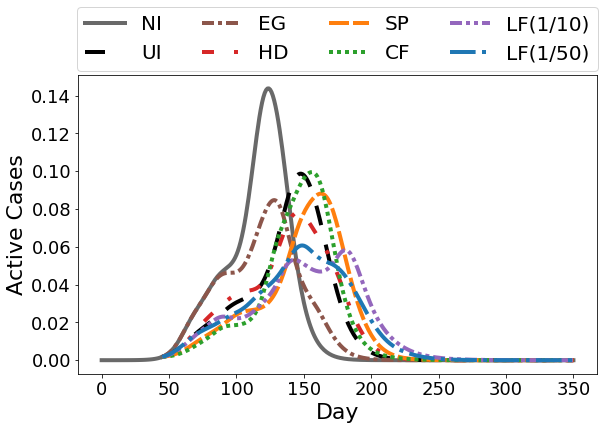

In [36]:
# time span
t_delay = 45.
t_end = 350.
t_span = (t_delay, t_end)

# delayed initial conditions
sol = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond, (0.,t_delay), phi=.071) 
ini_cond_delay = sol[-1]

# simulation
sol_ni = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond_delay, t_span, phi=.071)
sol_ui = Main.run_network_seir(Main.scipyCSC_to_julia(A_ui), ini_cond_delay, t_span, phi=.071)
sol_hd = Main.run_network_seir(Main.scipyCSC_to_julia(A_hd), ini_cond_delay, t_span, phi=.071)
sol_eg = Main.run_network_seir(Main.scipyCSC_to_julia(A_eg), ini_cond_delay, t_span, phi=.071)
sol_sp = Main.run_network_seir(Main.scipyCSC_to_julia(A_sp), ini_cond_delay, t_span, phi=.071)
sol_rw = Main.run_network_seir(Main.scipyCSC_to_julia(A_rw), ini_cond_delay, t_span, phi=.071)
sol_lf10 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf10), ini_cond_delay, t_span, phi=.071)
sol_lf02 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf02), ini_cond_delay, t_span, phi=.071)

# get curves and make plot
sum_s, sum_e, sum_i, sum_r = get_data_for_plotting(sol)
sum_s_ni, sum_e_ni, sum_i_ni, sum_r_ni = get_data_for_plotting(sol_ni)
sum_s_ui, sum_e_ui, sum_i_ui, sum_r_ui = get_data_for_plotting(sol_ui)
sum_s_hd, sum_e_hd, sum_i_hd, sum_r_hd = get_data_for_plotting(sol_hd)
sum_s_eg, sum_e_eg, sum_i_eg, sum_r_eg = get_data_for_plotting(sol_eg)
sum_s_sp, sum_e_sp, sum_i_sp, sum_r_sp = get_data_for_plotting(sol_sp)
sum_s_rw, sum_e_rw, sum_i_rw, sum_r_rw = get_data_for_plotting(sol_rw)
sum_s_lf10, sum_e_lf10, sum_i_lf10, sum_r_lf10 = get_data_for_plotting(sol_lf10)
sum_s_lf02, sum_e_lf02, sum_i_lf02, sum_r_lf02 = get_data_for_plotting(sol_lf02)

t_ini = np.linspace(0, int(t_delay), num=int(t_delay)+1)
t_int = np.linspace(t_delay, int(t_end), num=int(t_end-t_delay)+1)

plt.figure(figsize=(9.3,5.5))
plt.plot(t_ini,(sum_e+sum_i)/total_population, linestyle='-', color='dimgray', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_ni+sum_i_ni)/total_population, label='NI', linestyle='-', color='dimgray', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_ui+sum_i_ui)/total_population, label='UI', linestyle=(0,(5,5)), color='k', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_eg+sum_i_eg)/total_population, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=4)
plt.plot(t_int,(sum_e_hd+sum_i_hd)/total_population, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_sp+sum_i_sp)/total_population, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_rw+sum_i_rw)/total_population, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_lf10+sum_i_lf10)/total_population, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=4)
plt.plot(t_int,(sum_e_lf02+sum_i_lf02)/total_population, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=4)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel('Day', fontsize=22)
plt.ylabel('Active Cases',fontsize=22)
plt.savefig("facebook_curves__chicago_R025_delay45.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

#### Predicted epidemic curve: $R_0 = 2.5$, random initialization, delay = 30 days, 25% intervention

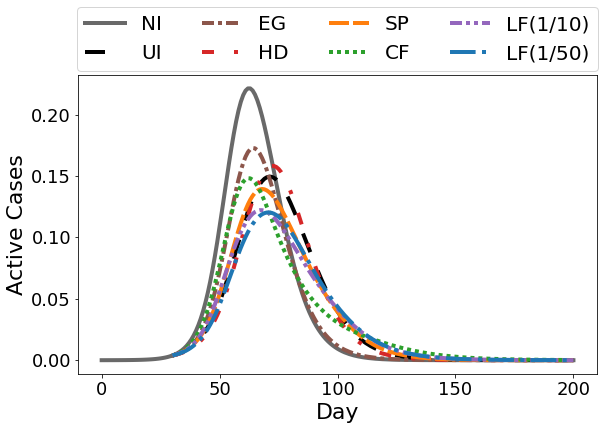

In [23]:
# time span
t_delay = 30.
t_end = 200.
t_span = (t_delay, t_end)

# time span
t_delay = 30.
t_end = 200.
t_span = (t_delay, t_end)

# delayed initial conditions
sol = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond, (0.,t_delay), phi=.071) 
ini_cond_delay = sol[-1]

# simulation
sol_ni = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond_delay, t_span, phi=.071)
sol_ui = Main.run_network_seir(Main.scipyCSC_to_julia(A_ui), ini_cond_delay, t_span, phi=.071)
sol_hd = Main.run_network_seir(Main.scipyCSC_to_julia(A_hd), ini_cond_delay, t_span, phi=.071)
sol_eg = Main.run_network_seir(Main.scipyCSC_to_julia(A_eg), ini_cond_delay, t_span, phi=.071)
sol_sp = Main.run_network_seir(Main.scipyCSC_to_julia(A_sp), ini_cond_delay, t_span, phi=.071)
sol_rw = Main.run_network_seir(Main.scipyCSC_to_julia(A_rw), ini_cond_delay, t_span, phi=.071)
sol_lf10 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf10), ini_cond_delay, t_span, phi=.071)
sol_lf02 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf02), ini_cond_delay, t_span, phi=.071)

# get curves and make plot
sum_s, sum_e, sum_i, sum_r = get_data_for_plotting(sol)
sum_s_ni, sum_e_ni, sum_i_ni, sum_r_ni = get_data_for_plotting(sol_ni)
sum_s_ui, sum_e_ui, sum_i_ui, sum_r_ui = get_data_for_plotting(sol_ui)
sum_s_hd, sum_e_hd, sum_i_hd, sum_r_hd = get_data_for_plotting(sol_hd)
sum_s_eg, sum_e_eg, sum_i_eg, sum_r_eg = get_data_for_plotting(sol_eg)
sum_s_sp, sum_e_sp, sum_i_sp, sum_r_sp = get_data_for_plotting(sol_sp)
sum_s_rw, sum_e_rw, sum_i_rw, sum_r_rw = get_data_for_plotting(sol_rw)
sum_s_lf10, sum_e_lf10, sum_i_lf10, sum_r_lf10 = get_data_for_plotting(sol_lf10)
sum_s_lf02, sum_e_lf02, sum_i_lf02, sum_r_lf02 = get_data_for_plotting(sol_lf02)

t_ini = np.linspace(0, int(t_delay), num=int(t_delay)+1)
t_int = np.linspace(t_delay, int(t_end), num=int(t_end-t_delay)+1)

plt.figure(figsize=(9.3,5.5))
plt.plot(t_ini,(sum_e+sum_i)/total_population, linestyle='-', color='dimgray', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_ni+sum_i_ni)/total_population, label='NI', linestyle='-', color='dimgray', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_ui+sum_i_ui)/total_population, label='UI', linestyle=(0,(5,5)), color='k', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_eg+sum_i_eg)/total_population, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=4)
plt.plot(t_int,(sum_e_hd+sum_i_hd)/total_population, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_sp+sum_i_sp)/total_population, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_rw+sum_i_rw)/total_population, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_lf10+sum_i_lf10)/total_population, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=4)
plt.plot(t_int,(sum_e_lf02+sum_i_lf02)/total_population, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=4)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((0,50,100,150,200), size=18)
plt.yticks((0,.05,.10,.15,.20), size=18)
plt.xlabel('Day', fontsize=22)
plt.ylabel('Active Cases',fontsize=22)
plt.savefig("facebook_curves_randinit_R025_delay30.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

#### Predicted epidemic curve: $R_0 = 2.5$, random initialization, delay = 45 days, 25% intervention

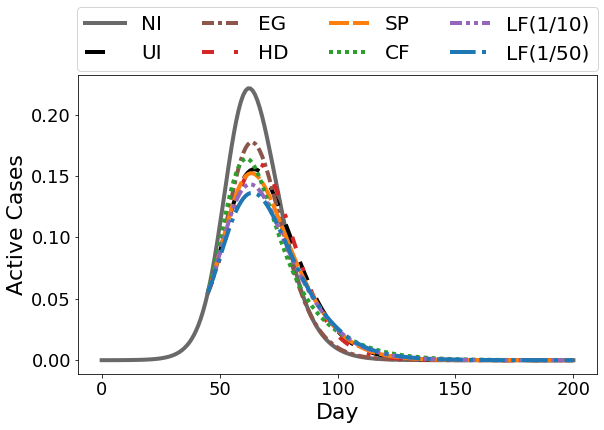

In [24]:
# time span
t_delay = 45.
t_end = 200.
t_span = (t_delay, t_end)

# delayed initial conditions
sol = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond, (0.,t_delay), phi=.071) 
ini_cond_delay = sol[-1]

# simulation
sol_ni = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond_delay, t_span, phi=.071)
sol_ui = Main.run_network_seir(Main.scipyCSC_to_julia(A_ui), ini_cond_delay, t_span, phi=.071)
sol_hd = Main.run_network_seir(Main.scipyCSC_to_julia(A_hd), ini_cond_delay, t_span, phi=.071)
sol_eg = Main.run_network_seir(Main.scipyCSC_to_julia(A_eg), ini_cond_delay, t_span, phi=.071)
sol_sp = Main.run_network_seir(Main.scipyCSC_to_julia(A_sp), ini_cond_delay, t_span, phi=.071)
sol_rw = Main.run_network_seir(Main.scipyCSC_to_julia(A_rw), ini_cond_delay, t_span, phi=.071)
sol_lf10 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf10), ini_cond_delay, t_span, phi=.071)
sol_lf02 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf02), ini_cond_delay, t_span, phi=.071)

# get curves and make plot
sum_s, sum_e, sum_i, sum_r = get_data_for_plotting(sol)
sum_s_ni, sum_e_ni, sum_i_ni, sum_r_ni = get_data_for_plotting(sol_ni)
sum_s_ui, sum_e_ui, sum_i_ui, sum_r_ui = get_data_for_plotting(sol_ui)
sum_s_hd, sum_e_hd, sum_i_hd, sum_r_hd = get_data_for_plotting(sol_hd)
sum_s_eg, sum_e_eg, sum_i_eg, sum_r_eg = get_data_for_plotting(sol_eg)
sum_s_sp, sum_e_sp, sum_i_sp, sum_r_sp = get_data_for_plotting(sol_sp)
sum_s_rw, sum_e_rw, sum_i_rw, sum_r_rw = get_data_for_plotting(sol_rw)
sum_s_lf10, sum_e_lf10, sum_i_lf10, sum_r_lf10 = get_data_for_plotting(sol_lf10)
sum_s_lf02, sum_e_lf02, sum_i_lf02, sum_r_lf02 = get_data_for_plotting(sol_lf02)

t_ini = np.linspace(0, int(t_delay), num=int(t_delay)+1)
t_int = np.linspace(t_delay, int(t_end), num=int(t_end-t_delay)+1)

plt.figure(figsize=(9.3,5.5))
plt.plot(t_ini,(sum_e+sum_i)/total_population, linestyle='-', color='dimgray', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_ni+sum_i_ni)/total_population, label='NI', linestyle='-', color='dimgray', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_ui+sum_i_ui)/total_population, label='UI', linestyle=(0,(5,5)), color='k', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_eg+sum_i_eg)/total_population, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=4)
plt.plot(t_int,(sum_e_hd+sum_i_hd)/total_population, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_sp+sum_i_sp)/total_population, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_rw+sum_i_rw)/total_population, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_lf10+sum_i_lf10)/total_population, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=4)
plt.plot(t_int,(sum_e_lf02+sum_i_lf02)/total_population, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=4)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((0,50,100,150,200), size=18)
plt.yticks((0,.05,.10,.15,.20), size=18)
plt.xlabel('Day', fontsize=22)
plt.ylabel('Active Cases',fontsize=22)
plt.savefig("facebook_curves_randinit_R025_delay45.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

#### Predicted epidemic curve: $R_0 = 2.5$, random initialization, delay = 60 days, 25% intervention

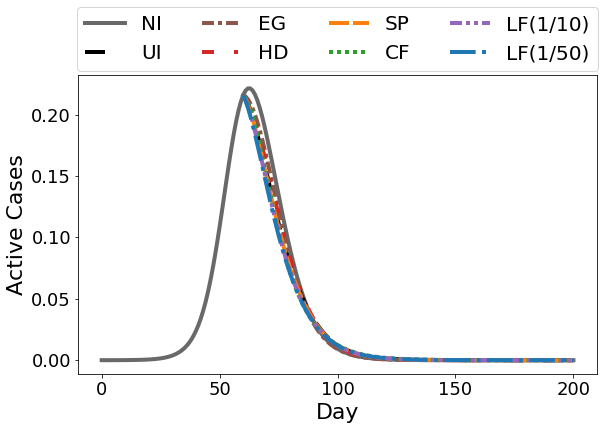

In [25]:
# time span
t_delay = 60.
t_end = 200.
t_span = (t_delay, t_end)

# delayed initial conditions
sol = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond, (0.,t_delay), phi=.071) 
ini_cond_delay = sol[-1]

# simulation
sol_ni = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond_delay, t_span, phi=.071)
sol_ui = Main.run_network_seir(Main.scipyCSC_to_julia(A_ui), ini_cond_delay, t_span, phi=.071)
sol_hd = Main.run_network_seir(Main.scipyCSC_to_julia(A_hd), ini_cond_delay, t_span, phi=.071)
sol_eg = Main.run_network_seir(Main.scipyCSC_to_julia(A_eg), ini_cond_delay, t_span, phi=.071)
sol_sp = Main.run_network_seir(Main.scipyCSC_to_julia(A_sp), ini_cond_delay, t_span, phi=.071)
sol_rw = Main.run_network_seir(Main.scipyCSC_to_julia(A_rw), ini_cond_delay, t_span, phi=.071)
sol_lf10 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf10), ini_cond_delay, t_span, phi=.071)
sol_lf02 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf02), ini_cond_delay, t_span, phi=.071)

# get curves and make plot
sum_s, sum_e, sum_i, sum_r = get_data_for_plotting(sol)
sum_s_ni, sum_e_ni, sum_i_ni, sum_r_ni = get_data_for_plotting(sol_ni)
sum_s_ui, sum_e_ui, sum_i_ui, sum_r_ui = get_data_for_plotting(sol_ui)
sum_s_hd, sum_e_hd, sum_i_hd, sum_r_hd = get_data_for_plotting(sol_hd)
sum_s_eg, sum_e_eg, sum_i_eg, sum_r_eg = get_data_for_plotting(sol_eg)
sum_s_sp, sum_e_sp, sum_i_sp, sum_r_sp = get_data_for_plotting(sol_sp)
sum_s_rw, sum_e_rw, sum_i_rw, sum_r_rw = get_data_for_plotting(sol_rw)
sum_s_lf10, sum_e_lf10, sum_i_lf10, sum_r_lf10 = get_data_for_plotting(sol_lf10)
sum_s_lf02, sum_e_lf02, sum_i_lf02, sum_r_lf02 = get_data_for_plotting(sol_lf02)

t_ini = np.linspace(0, int(t_delay), num=int(t_delay)+1)
t_int = np.linspace(t_delay, int(t_end), num=int(t_end-t_delay)+1)

plt.figure(figsize=(9.3,5.5))
plt.plot(t_ini,(sum_e+sum_i)/total_population, linestyle='-', color='dimgray', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_ni+sum_i_ni)/total_population, label='NI', linestyle='-', color='dimgray', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_ui+sum_i_ui)/total_population, label='UI', linestyle=(0,(5,5)), color='k', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_eg+sum_i_eg)/total_population, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=4)
plt.plot(t_int,(sum_e_hd+sum_i_hd)/total_population, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_sp+sum_i_sp)/total_population, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_rw+sum_i_rw)/total_population, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_lf10+sum_i_lf10)/total_population, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=4)
plt.plot(t_int,(sum_e_lf02+sum_i_lf02)/total_population, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=4)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((0,50,100,150,200), size=18)
plt.yticks((0,.05,.10,.15,.20), size=18)
plt.xlabel('Day', fontsize=22)
plt.ylabel('Active Cases',fontsize=22)
plt.savefig("facebook_curves_randinit_R025_delay60.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

## Simulation for interventions that start on day 0, random initialization, $R_0 = 2.5$

In [26]:
reduced_weight = .1
target_perc = [.05, .1, .15, .2, .25, .3, .35, .4, .45, .5]
num_scenarios = len(target_perc)
num_trials = 1

maxCases_ni = np.zeros((num_trials,num_scenarios))
maxCases_ui = np.zeros((num_trials,num_scenarios))
maxCases_hd = np.zeros((num_trials,num_scenarios))
maxCases_eg = np.zeros((num_trials,num_scenarios))
maxCases_sp = np.zeros((num_trials,num_scenarios))
maxCases_rw = np.zeros((num_trials,num_scenarios))
maxCases_lf10 = np.zeros((num_trials,num_scenarios))
maxCases_lf02 = np.zeros((num_trials,num_scenarios))
totalCases_ni = np.zeros((num_trials,num_scenarios))
totalCases_ui = np.zeros((num_trials,num_scenarios))
totalCases_hd = np.zeros((num_trials,num_scenarios))
totalCases_eg = np.zeros((num_trials,num_scenarios))
totalCases_sp = np.zeros((num_trials,num_scenarios))
totalCases_rw = np.zeros((num_trials,num_scenarios))
totalCases_lf10 = np.zeros((num_trials,num_scenarios))
totalCases_lf02 = np.zeros((num_trials,num_scenarios))

for k in range(num_scenarios):
    
    perc = target_perc[k]
    A_ui = ((1-(1-reduced_weight)*perc)*nx.adjacency_matrix(G) + sp.sparse.eye(G.number_of_nodes())).tocsc()
    A_hd = create_weighted_adjacency_from_degree_dist(G, perc, weight=reduced_weight)
    A_eg = create_weighted_adjacency_from_node_betweenness(G, eigenvector_centrality, perc, weight=reduced_weight)
    A_sp = create_weighted_adjacency_from_edge_betweenness(G, shortest_path_betweenness, perc, weight=reduced_weight)
    A_rw = create_weighted_adjacency_from_edge_betweenness(G, current_flow_betweenness, perc, weight=reduced_weight)
    A_lf10 = create_weighted_adjacency_from_edge_betweenness(G, local10_betweenness, perc, weight=reduced_weight)
    A_lf02 = create_weighted_adjacency_from_edge_betweenness(G, local02_betweenness, perc, weight=reduced_weight)
    
    for trial in range(num_trials):
        
        print(f'perc = {perc:.2f}, trial {trial+1:d} of {num_trials:d}', end="\r")
    
        S_0 = np.zeros(n)
        E_0 = np.zeros(n)
        I_0 = np.zeros(n)
        R_0 = np.zeros(n)
        for i in range(n):
            S_0[i] = populations[map_to_original[i+1]]
        """
        for i in sample(range(n),31):
            E_0[i] = 0
            I_0[i] = populations[map_to_original[i+1]] * .001
            S_0[i] = S_0[i] - E_0[i] - I_0[i]
        """
            
        # the following lines set up Chicago initialization
        for i in range(n):
            county_no = map_to_original[i+1]
            if labels[county_no] =='Cook, IL':
                E_0[i] = 0
                I_0[i] = populations[county_no] * .001
                S_0[i] = S_0[i] - E_0[i] - I_0[i]

        ini_cond = np.column_stack((S_0,E_0,I_0,R_0))
        t_span = (0.,1000.)
        
        sol_ni = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond, t_span, phi=.071)
        sol_ui = Main.run_network_seir(Main.scipyCSC_to_julia(A_ui), ini_cond, t_span, phi=.071)
        sol_hd = Main.run_network_seir(Main.scipyCSC_to_julia(A_hd), ini_cond, t_span, phi=.071)
        sol_eg = Main.run_network_seir(Main.scipyCSC_to_julia(A_eg), ini_cond, t_span, phi=.071)
        sol_sp = Main.run_network_seir(Main.scipyCSC_to_julia(A_sp), ini_cond, t_span, phi=.071)
        sol_rw = Main.run_network_seir(Main.scipyCSC_to_julia(A_rw), ini_cond, t_span, phi=.071)
        sol_lf10 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf10), ini_cond, t_span, phi=.071)
        sol_lf02 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf02), ini_cond, t_span, phi=.071) 
        maxCases_ni[trial,k] = get_max_active_cases(sol_ni)
        maxCases_ui[trial,k] = get_max_active_cases(sol_ui)
        maxCases_hd[trial,k] = get_max_active_cases(sol_hd)
        maxCases_eg[trial,k] = get_max_active_cases(sol_eg)
        maxCases_sp[trial,k] = get_max_active_cases(sol_sp)
        maxCases_rw[trial,k] = get_max_active_cases(sol_rw)
        maxCases_lf10[trial,k] = get_max_active_cases(sol_lf10)
        maxCases_lf02[trial,k] = get_max_active_cases(sol_lf02)
        totalCases_ni[trial,k] = get_total_active_cases(sol_ni)
        totalCases_ui[trial,k] = get_total_active_cases(sol_ui)
        totalCases_hd[trial,k] = get_total_active_cases(sol_hd)
        totalCases_eg[trial,k] = get_total_active_cases(sol_eg)
        totalCases_sp[trial,k] = get_total_active_cases(sol_sp)
        totalCases_rw[trial,k] = get_total_active_cases(sol_rw)
        totalCases_lf10[trial,k] = get_total_active_cases(sol_lf10)
        totalCases_lf02[trial,k] = get_total_active_cases(sol_lf02)

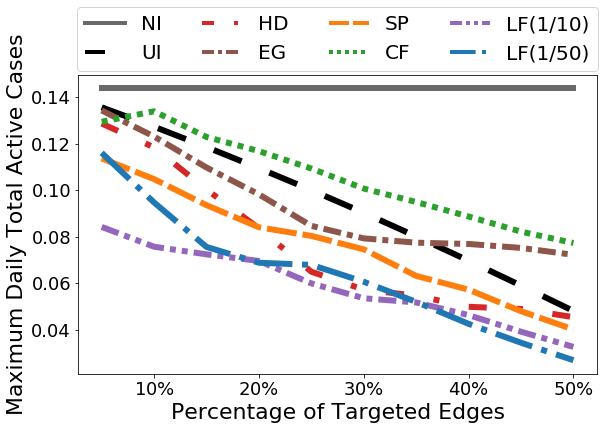

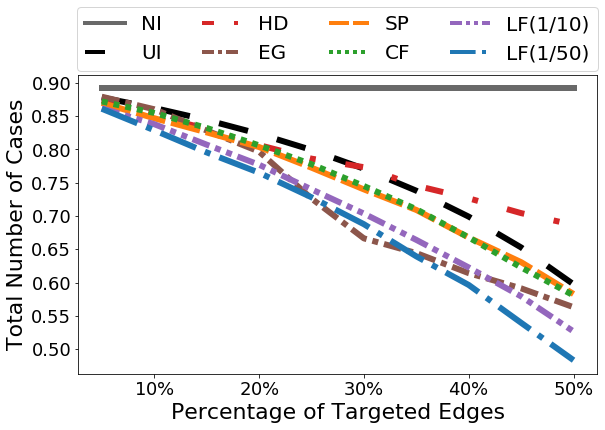

In [27]:
maxCases_ni_mean = np.mean(maxCases_ni/total_population, axis=0)
maxCases_ui_mean = np.mean(maxCases_ui/total_population, axis=0)
maxCases_hd_mean = np.mean(maxCases_hd/total_population, axis=0)
maxCases_eg_mean = np.mean(maxCases_eg/total_population, axis=0)
maxCases_sp_mean = np.mean(maxCases_sp/total_population, axis=0)
maxCases_rw_mean = np.mean(maxCases_rw/total_population, axis=0)
maxCases_lf10_mean = np.mean(maxCases_lf10/total_population, axis=0)
maxCases_lf02_mean = np.mean(maxCases_lf02/total_population, axis=0)
totalCases_ni_mean = np.mean(totalCases_ni/total_population, axis=0)
totalCases_ui_mean = np.mean(totalCases_ui/total_population, axis=0)
totalCases_hd_mean = np.mean(totalCases_hd/total_population, axis=0)
totalCases_eg_mean = np.mean(totalCases_eg/total_population, axis=0)
totalCases_sp_mean = np.mean(totalCases_sp/total_population, axis=0)
totalCases_rw_mean = np.mean(totalCases_rw/total_population, axis=0)
totalCases_lf10_mean = np.mean(totalCases_lf10/total_population, axis=0)
totalCases_lf02_mean = np.mean(totalCases_lf02/total_population, axis=0)

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, maxCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, maxCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, maxCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, maxCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks(size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Maximum Daily Total Active Cases',fontsize=22)
plt.savefig("facebook_epipeak_chicago_R025.png", bbox_inches='tight', format='png', dpi=400)
plt.show()
                                      
plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, totalCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, totalCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, totalCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, totalCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks(size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Total Number of Cases',fontsize=22)
plt.savefig("facebook_episize_chicago_R025.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

## Simulation for interventions that start on day 45, random initialization, $R_0 = 2.5$

In [28]:
reduced_weight = .1
target_perc = [.05, .1, .15, .2, .25, .3, .35, .4, .45, .5]
num_scenarios = len(target_perc)
num_trials = 1

maxCases_ni = np.zeros((num_trials,num_scenarios))
maxCases_ui = np.zeros((num_trials,num_scenarios))
maxCases_hd = np.zeros((num_trials,num_scenarios))
maxCases_eg = np.zeros((num_trials,num_scenarios))
maxCases_sp = np.zeros((num_trials,num_scenarios))
maxCases_rw = np.zeros((num_trials,num_scenarios))
maxCases_lf10 = np.zeros((num_trials,num_scenarios))
maxCases_lf02 = np.zeros((num_trials,num_scenarios))
totalCases_ni = np.zeros((num_trials,num_scenarios))
totalCases_ui = np.zeros((num_trials,num_scenarios))
totalCases_hd = np.zeros((num_trials,num_scenarios))
totalCases_eg = np.zeros((num_trials,num_scenarios))
totalCases_sp = np.zeros((num_trials,num_scenarios))
totalCases_rw = np.zeros((num_trials,num_scenarios))
totalCases_lf10 = np.zeros((num_trials,num_scenarios))
totalCases_lf02 = np.zeros((num_trials,num_scenarios))

for k in range(num_scenarios):
    
    perc = target_perc[k]
    A_ui = ((1-(1-reduced_weight)*perc)*nx.adjacency_matrix(G) + sp.sparse.eye(G.number_of_nodes())).tocsc()
    A_hd = create_weighted_adjacency_from_degree_dist(G, perc, weight=reduced_weight)
    A_eg = create_weighted_adjacency_from_node_betweenness(G, eigenvector_centrality, perc, weight=reduced_weight)
    A_sp = create_weighted_adjacency_from_edge_betweenness(G, shortest_path_betweenness, perc, weight=reduced_weight)
    A_rw = create_weighted_adjacency_from_edge_betweenness(G, current_flow_betweenness, perc, weight=reduced_weight)
    A_lf10 = create_weighted_adjacency_from_edge_betweenness(G, local10_betweenness, perc, weight=reduced_weight)
    A_lf02 = create_weighted_adjacency_from_edge_betweenness(G, local02_betweenness, perc, weight=reduced_weight)
    
    for trial in range(num_trials):
        
        print(f'perc = {perc:.2f}, trial {trial+1:d} of {num_trials}', end="\r")
    
        S_0 = np.zeros(n)
        E_0 = np.zeros(n)
        I_0 = np.zeros(n)
        R_0 = np.zeros(n)
        for i in range(n):
            S_0[i] = populations[map_to_original[i+1]]
        """
        for i in sample(range(n),31):
            E_0[i] = 0
            I_0[i] = populations[map_to_original[i+1]] * .001
            S_0[i] = S_0[i] - E_0[i] - I_0[i]
        """
            
        # the following lines set up Chicago initialization
        for i in range(n):
            county_no = map_to_original[i+1]
            if labels[county_no] =='Cook, IL':
                E_0[i] = 0
                I_0[i] = populations[county_no] * .001
                S_0[i] = S_0[i] - E_0[i] - I_0[i]
        
        ini_cond = np.column_stack((S_0,E_0,I_0,R_0))
        t_span = (0.,45.)
        sol = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond, t_span, phi=.071)
        
        ini_cond = sol[-1]
        t_span = (0.,500.)
        
        sol_ni = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond, t_span, phi=.071)
        sol_ui = Main.run_network_seir(Main.scipyCSC_to_julia(A_ui), ini_cond, t_span, phi=.071)
        sol_hd = Main.run_network_seir(Main.scipyCSC_to_julia(A_hd), ini_cond, t_span, phi=.071)
        sol_eg = Main.run_network_seir(Main.scipyCSC_to_julia(A_eg), ini_cond, t_span, phi=.071)
        sol_sp = Main.run_network_seir(Main.scipyCSC_to_julia(A_sp), ini_cond, t_span, phi=.071)
        sol_rw = Main.run_network_seir(Main.scipyCSC_to_julia(A_rw), ini_cond, t_span, phi=.071)
        sol_lf10 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf10), ini_cond, t_span, phi=.071)
        sol_lf02 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf02), ini_cond, t_span, phi=.071) 
        maxCases_ni[trial,k] = get_max_active_cases(sol_ni)
        maxCases_ui[trial,k] = get_max_active_cases(sol_ui)
        maxCases_hd[trial,k] = get_max_active_cases(sol_hd)
        maxCases_eg[trial,k] = get_max_active_cases(sol_eg)
        maxCases_sp[trial,k] = get_max_active_cases(sol_sp)
        maxCases_rw[trial,k] = get_max_active_cases(sol_rw)
        maxCases_lf10[trial,k] = get_max_active_cases(sol_lf10)
        maxCases_lf02[trial,k] = get_max_active_cases(sol_lf02)
        totalCases_ni[trial,k] = get_total_active_cases(sol_ni)
        totalCases_ui[trial,k] = get_total_active_cases(sol_ui)
        totalCases_hd[trial,k] = get_total_active_cases(sol_hd)
        totalCases_eg[trial,k] = get_total_active_cases(sol_eg)
        totalCases_sp[trial,k] = get_total_active_cases(sol_sp)
        totalCases_rw[trial,k] = get_total_active_cases(sol_rw)
        totalCases_lf10[trial,k] = get_total_active_cases(sol_lf10)
        totalCases_lf02[trial,k] = get_total_active_cases(sol_lf02)

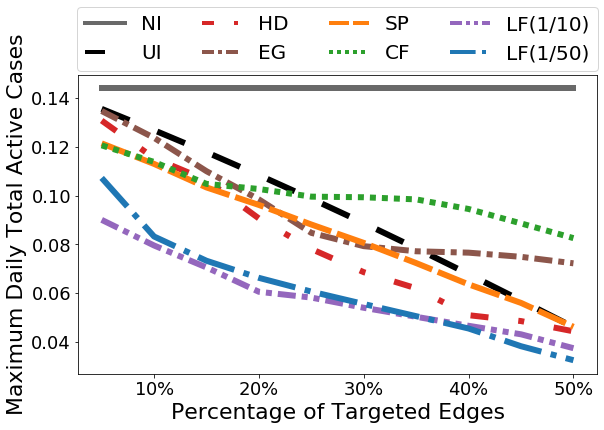

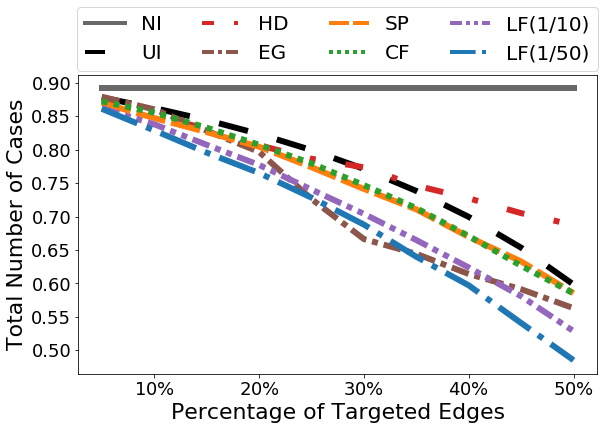

In [30]:
maxCases_ni_mean = np.mean(maxCases_ni/total_population, axis=0)
maxCases_ui_mean = np.mean(maxCases_ui/total_population, axis=0)
maxCases_hd_mean = np.mean(maxCases_hd/total_population, axis=0)
maxCases_eg_mean = np.mean(maxCases_eg/total_population, axis=0)
maxCases_sp_mean = np.mean(maxCases_sp/total_population, axis=0)
maxCases_rw_mean = np.mean(maxCases_rw/total_population, axis=0)
maxCases_lf10_mean = np.mean(maxCases_lf10/total_population, axis=0)
maxCases_lf02_mean = np.mean(maxCases_lf02/total_population, axis=0)
totalCases_ni_mean = np.mean(totalCases_ni/total_population, axis=0)
totalCases_ui_mean = np.mean(totalCases_ui/total_population, axis=0)
totalCases_hd_mean = np.mean(totalCases_hd/total_population, axis=0)
totalCases_eg_mean = np.mean(totalCases_eg/total_population, axis=0)
totalCases_sp_mean = np.mean(totalCases_sp/total_population, axis=0)
totalCases_rw_mean = np.mean(totalCases_rw/total_population, axis=0)
totalCases_lf10_mean = np.mean(totalCases_lf10/total_population, axis=0)
totalCases_lf02_mean = np.mean(totalCases_lf02/total_population, axis=0)

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, maxCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, maxCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, maxCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, maxCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks(size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Maximum Daily Total Active Cases',fontsize=22)
plt.savefig("facebook_epipeak_chicago_R025_delay45.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, totalCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, totalCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, totalCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, totalCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks( size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Total Number of Cases',fontsize=22)
plt.savefig("facebook_episize_chicago_R025_delay45.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

## Scenario 2: $R_0 = 1.5$

#### Verify that $\beta$ is set appropriately

In [30]:
# initial conditions
S_0 = np.zeros(n)
E_0 = np.zeros(n)
I_0 = np.zeros(n)
R_0 = np.zeros(n)
for i in range(n):
    S_0[i] = populations[map_to_original[i+1]] 
for i in sample(range(n),31):
    E_0[i] = 0
    I_0[i] = populations[map_to_original[i+1]] * .001
    S_0[i] = S_0[i] - E_0[i] - I_0[i]
    
ini_cond = np.column_stack((S_0,E_0,I_0,R_0))

# time span
t_end = 500.
t_span = (0.,t_end)

sol = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond, t_span, R_0=1.5, phi=.068)
print(f'This should be around 0.59: {get_total_active_cases(sol)/total_population:.6f}')

This should be around 0.59: 0.589765


### Sample epidemic curves

In [31]:
perc = .25
reduced_weight = .1

In [32]:
A_ui = ((1-(1-reduced_weight)*perc)*nx.adjacency_matrix(G) + sp.sparse.eye(G.number_of_nodes())).tocsc()
A_hd = create_weighted_adjacency_from_degree_dist(G, perc, weight=reduced_weight)
A_eg = create_weighted_adjacency_from_node_betweenness(G, eigenvector_centrality, perc, weight=reduced_weight)
A_sp = create_weighted_adjacency_from_edge_betweenness(G, shortest_path_betweenness, perc, weight=reduced_weight)
A_rw = create_weighted_adjacency_from_edge_betweenness(G, current_flow_betweenness, perc, weight=reduced_weight)
A_lf10 = create_weighted_adjacency_from_edge_betweenness(G, local10_betweenness, perc, weight=reduced_weight)
A_lf02 = create_weighted_adjacency_from_edge_betweenness(G, local02_betweenness, perc, weight=reduced_weight)

#### Predicted epidemic curve: $R_0 = 1.5$, random initialization, no delay, 25% intervention

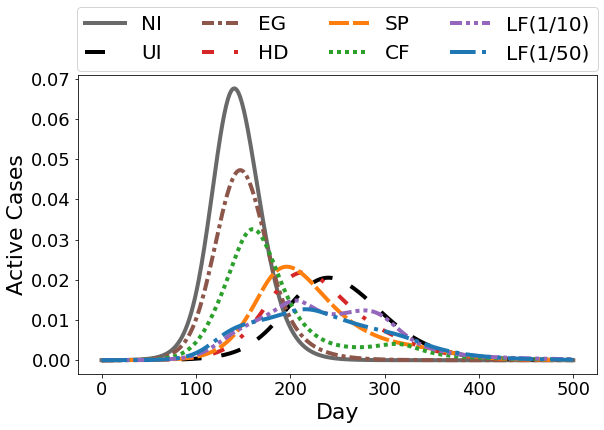

In [33]:
# time span
t_end = 500.
t_span = (0., t_end)

# initial conditions
n = G.number_of_nodes()
S_0 = np.zeros(n)
E_0 = np.zeros(n)
I_0 = np.zeros(n)
R_0 = np.zeros(n)
for i in range(n):
    S_0[i] = populations[map_to_original[i+1]]
for i in sample(range(n),31):
    E_0[i] = 0
    I_0[i] = populations[map_to_original[i+1]] * .001
    S_0[i] = S_0[i] - E_0[i] - I_0[i]

ini_cond = np.column_stack((S_0,E_0,I_0,R_0))

# simulation
sol_ni = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond, t_span, R_0=1.5, phi=.068)
sol_ui = Main.run_network_seir(Main.scipyCSC_to_julia(A_ui), ini_cond, t_span, R_0=1.5, phi=.068)
sol_hd = Main.run_network_seir(Main.scipyCSC_to_julia(A_hd), ini_cond, t_span, R_0=1.5, phi=.068)
sol_eg = Main.run_network_seir(Main.scipyCSC_to_julia(A_eg), ini_cond, t_span, R_0=1.5, phi=.068)
sol_sp = Main.run_network_seir(Main.scipyCSC_to_julia(A_sp), ini_cond, t_span, R_0=1.5, phi=.068)
sol_rw = Main.run_network_seir(Main.scipyCSC_to_julia(A_rw), ini_cond, t_span, R_0=1.5, phi=.068)
sol_lf10 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf10), ini_cond, t_span, R_0=1.5, phi=.068)
sol_lf02 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf02), ini_cond, t_span, R_0=1.5, phi=.068)

# get curves and make plot
sum_s_ni, sum_e_ni, sum_i_ni, sum_r_ni = get_data_for_plotting(sol_ni)
sum_s_ui, sum_e_ui, sum_i_ui, sum_r_ui = get_data_for_plotting(sol_ui)
sum_s_hd, sum_e_hd, sum_i_hd, sum_r_hd = get_data_for_plotting(sol_hd)
sum_s_eg, sum_e_eg, sum_i_eg, sum_r_eg = get_data_for_plotting(sol_eg)
sum_s_sp, sum_e_sp, sum_i_sp, sum_r_sp = get_data_for_plotting(sol_sp)
sum_s_rw, sum_e_rw, sum_i_rw, sum_r_rw = get_data_for_plotting(sol_rw)
sum_s_lf10, sum_e_lf10, sum_i_lf10, sum_r_lf10 = get_data_for_plotting(sol_lf10)
sum_s_lf02, sum_e_lf02, sum_i_lf02, sum_r_lf02 = get_data_for_plotting(sol_lf02)

t_int = np.linspace(0, int(t_end), num=int(t_end)+1)

plt.figure(figsize=(9.3,5.5))
plt.plot(t_int,(sum_e_ni+sum_i_ni)/total_population, label='NI', linestyle='-', color='dimgray', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_ui+sum_i_ui)/total_population, label='UI', linestyle=(0,(5,5)), color='k', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_eg+sum_i_eg)/total_population, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=4)
plt.plot(t_int,(sum_e_hd+sum_i_hd)/total_population, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_sp+sum_i_sp)/total_population, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_rw+sum_i_rw)/total_population, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_lf10+sum_i_lf10)/total_population, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=4)
plt.plot(t_int,(sum_e_lf02+sum_i_lf02)/total_population, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=4)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel('Day', fontsize=22)
plt.ylabel('Active Cases',fontsize=22)
plt.savefig("facebook_curves_randinit_R015.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

#### Predicted epidemic curve: $R_0 = 1.5$, random initialization, delay = 60 days, 25% intervention

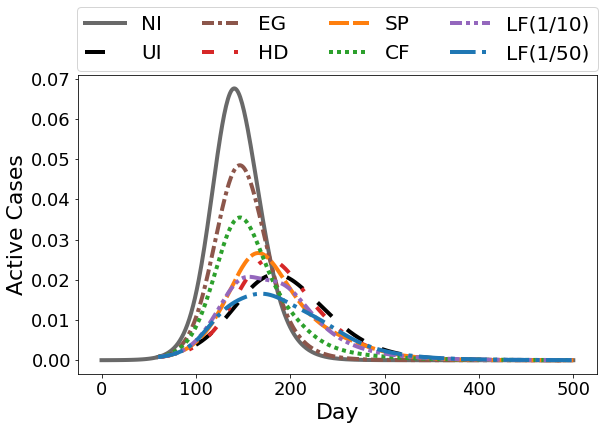

In [34]:
# time span
t_delay = 60.
t_end = 500.
t_span = (t_delay, t_end)

# delayed initial conditions
sol = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond, (0.,t_delay), R_0=1.5, phi=.068) 
ini_cond_delay = sol[-1]

# simulation
sol_ni = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond_delay, t_span, R_0=1.5, phi=.068)
sol_ui = Main.run_network_seir(Main.scipyCSC_to_julia(A_ui), ini_cond_delay, t_span, R_0=1.5, phi=.068)
sol_hd = Main.run_network_seir(Main.scipyCSC_to_julia(A_hd), ini_cond_delay, t_span, R_0=1.5, phi=.068)
sol_eg = Main.run_network_seir(Main.scipyCSC_to_julia(A_eg), ini_cond_delay, t_span, R_0=1.5, phi=.068)
sol_sp = Main.run_network_seir(Main.scipyCSC_to_julia(A_sp), ini_cond_delay, t_span, R_0=1.5, phi=.068)
sol_rw = Main.run_network_seir(Main.scipyCSC_to_julia(A_rw), ini_cond_delay, t_span, R_0=1.5, phi=.068)
sol_lf10 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf10), ini_cond_delay, t_span, R_0=1.5, phi=.068)
sol_lf02 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf02), ini_cond_delay, t_span, R_0=1.5, phi=.068)

# get curves and make plot
sum_s, sum_e, sum_i, sum_r = get_data_for_plotting(sol)
sum_s_ni, sum_e_ni, sum_i_ni, sum_r_ni = get_data_for_plotting(sol_ni)
sum_s_ui, sum_e_ui, sum_i_ui, sum_r_ui = get_data_for_plotting(sol_ui)
sum_s_hd, sum_e_hd, sum_i_hd, sum_r_hd = get_data_for_plotting(sol_hd)
sum_s_eg, sum_e_eg, sum_i_eg, sum_r_eg = get_data_for_plotting(sol_eg)
sum_s_sp, sum_e_sp, sum_i_sp, sum_r_sp = get_data_for_plotting(sol_sp)
sum_s_rw, sum_e_rw, sum_i_rw, sum_r_rw = get_data_for_plotting(sol_rw)
sum_s_lf10, sum_e_lf10, sum_i_lf10, sum_r_lf10 = get_data_for_plotting(sol_lf10)
sum_s_lf02, sum_e_lf02, sum_i_lf02, sum_r_lf02 = get_data_for_plotting(sol_lf02)

t_ini = np.linspace(0, int(t_delay), num=int(t_delay)+1)
t_int = np.linspace(t_delay, int(t_end), num=int(t_end-t_delay)+1)

plt.figure(figsize=(9.3,5.5))
plt.plot(t_ini,(sum_e+sum_i)/total_population, linestyle='-', color='dimgray', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_ni+sum_i_ni)/total_population, label='NI', linestyle='-', color='dimgray', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_ui+sum_i_ui)/total_population, label='UI', linestyle=(0,(5,5)), color='k', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_eg+sum_i_eg)/total_population, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=4)
plt.plot(t_int,(sum_e_hd+sum_i_hd)/total_population, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_sp+sum_i_sp)/total_population, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_rw+sum_i_rw)/total_population, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_lf10+sum_i_lf10)/total_population, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=4)
plt.plot(t_int,(sum_e_lf02+sum_i_lf02)/total_population, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=4)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel('Day', fontsize=22)
plt.ylabel('Active Cases',fontsize=22)
plt.savefig("facebook_curves_randinit_R015_delay60.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

## Simulation for interventions that start on day 0, random initialization, $R_0 = 1.5$

In [35]:
reduced_weight = .1
target_perc = [.05, .1, .15, .2, .25, .3, .35, .4, .45, .5]
num_scenarios = len(target_perc)
num_trials = 50

maxCases_ni = np.zeros((num_trials,num_scenarios))
maxCases_ui = np.zeros((num_trials,num_scenarios))
maxCases_hd = np.zeros((num_trials,num_scenarios))
maxCases_eg = np.zeros((num_trials,num_scenarios))
maxCases_sp = np.zeros((num_trials,num_scenarios))
maxCases_rw = np.zeros((num_trials,num_scenarios))
maxCases_lf10 = np.zeros((num_trials,num_scenarios))
maxCases_lf02 = np.zeros((num_trials,num_scenarios))
totalCases_ni = np.zeros((num_trials,num_scenarios))
totalCases_ui = np.zeros((num_trials,num_scenarios))
totalCases_hd = np.zeros((num_trials,num_scenarios))
totalCases_eg = np.zeros((num_trials,num_scenarios))
totalCases_sp = np.zeros((num_trials,num_scenarios))
totalCases_rw = np.zeros((num_trials,num_scenarios))
totalCases_lf10 = np.zeros((num_trials,num_scenarios))
totalCases_lf02 = np.zeros((num_trials,num_scenarios))

for k in range(num_scenarios):
    
    perc = target_perc[k]
    A_ui = ((1-(1-reduced_weight)*perc)*nx.adjacency_matrix(G) + sp.sparse.eye(G.number_of_nodes())).tocsc()
    A_hd = create_weighted_adjacency_from_degree_dist(G, perc, weight=reduced_weight)
    A_eg = create_weighted_adjacency_from_node_betweenness(G, eigenvector_centrality, perc, weight=reduced_weight)
    A_sp = create_weighted_adjacency_from_edge_betweenness(G, shortest_path_betweenness, perc, weight=reduced_weight)
    A_rw = create_weighted_adjacency_from_edge_betweenness(G, current_flow_betweenness, perc, weight=reduced_weight)
    A_lf10 = create_weighted_adjacency_from_edge_betweenness(G, local10_betweenness, perc, weight=reduced_weight)
    A_lf02 = create_weighted_adjacency_from_edge_betweenness(G, local02_betweenness, perc, weight=reduced_weight)
    
    for trial in range(num_trials):
        
        print(f'perc = {perc:.2f}, trial {trial+1:d} of {num_trials}', end="\r")
    
        S_0 = np.zeros(n)
        E_0 = np.zeros(n)
        I_0 = np.zeros(n)
        R_0 = np.zeros(n)
        for i in range(n):
            S_0[i] = populations[map_to_original[i+1]]
        for i in sample(range(n),31):
            E_0[i] = 0
            I_0[i] = populations[map_to_original[i+1]] * .001
            S_0[i] = S_0[i] - E_0[i] - I_0[i]
        
        ini_cond = np.column_stack((S_0,E_0,I_0,R_0))
        t_span = (0.,1000.)
        
        sol_ni = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond, t_span, R_0=1.5, phi=.068)
        sol_ui = Main.run_network_seir(Main.scipyCSC_to_julia(A_ui), ini_cond, t_span, R_0=1.5, phi=.068)
        sol_hd = Main.run_network_seir(Main.scipyCSC_to_julia(A_hd), ini_cond, t_span, R_0=1.5, phi=.068)
        sol_eg = Main.run_network_seir(Main.scipyCSC_to_julia(A_eg), ini_cond, t_span, R_0=1.5, phi=.068)
        sol_sp = Main.run_network_seir(Main.scipyCSC_to_julia(A_sp), ini_cond, t_span, R_0=1.5, phi=.068)
        sol_rw = Main.run_network_seir(Main.scipyCSC_to_julia(A_rw), ini_cond, t_span, R_0=1.5, phi=.068)
        sol_lf10 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf10), ini_cond, t_span, R_0=1.5, phi=.068)
        sol_lf02 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf02), ini_cond, t_span, R_0=1.5, phi=.068) 
        maxCases_ni[trial,k] = get_max_active_cases(sol_ni)
        maxCases_ui[trial,k] = get_max_active_cases(sol_ui)
        maxCases_hd[trial,k] = get_max_active_cases(sol_hd)
        maxCases_eg[trial,k] = get_max_active_cases(sol_eg)
        maxCases_sp[trial,k] = get_max_active_cases(sol_sp)
        maxCases_rw[trial,k] = get_max_active_cases(sol_rw)
        maxCases_lf10[trial,k] = get_max_active_cases(sol_lf10)
        maxCases_lf02[trial,k] = get_max_active_cases(sol_lf02)
        totalCases_ni[trial,k] = get_total_active_cases(sol_ni)
        totalCases_ui[trial,k] = get_total_active_cases(sol_ui)
        totalCases_hd[trial,k] = get_total_active_cases(sol_hd)
        totalCases_eg[trial,k] = get_total_active_cases(sol_eg)
        totalCases_sp[trial,k] = get_total_active_cases(sol_sp)
        totalCases_rw[trial,k] = get_total_active_cases(sol_rw)
        totalCases_lf10[trial,k] = get_total_active_cases(sol_lf10)
        totalCases_lf02[trial,k] = get_total_active_cases(sol_lf02)

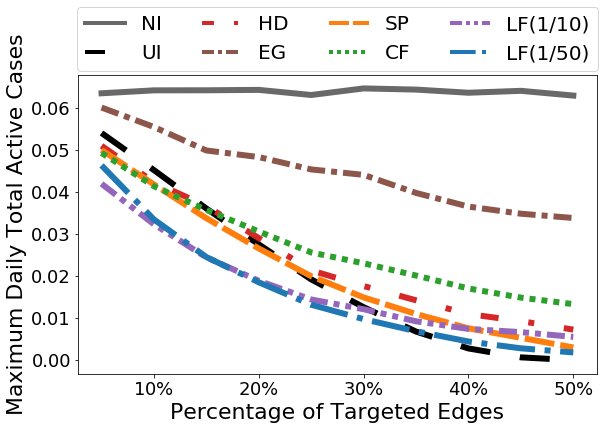

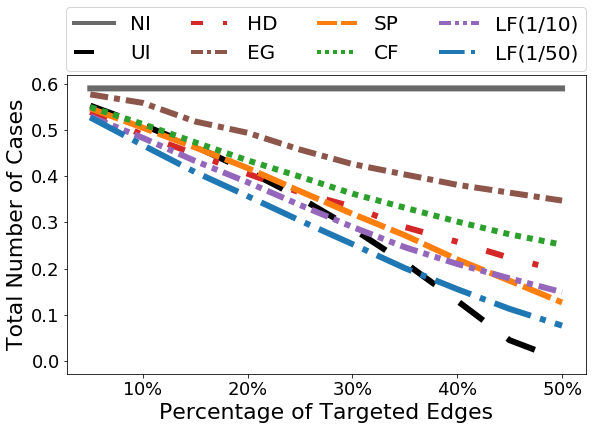

In [36]:
maxCases_ni_mean = np.mean(maxCases_ni/total_population, axis=0)
maxCases_ui_mean = np.mean(maxCases_ui/total_population, axis=0)
maxCases_hd_mean = np.mean(maxCases_hd/total_population, axis=0)
maxCases_eg_mean = np.mean(maxCases_eg/total_population, axis=0)
maxCases_sp_mean = np.mean(maxCases_sp/total_population, axis=0)
maxCases_rw_mean = np.mean(maxCases_rw/total_population, axis=0)
maxCases_lf10_mean = np.mean(maxCases_lf10/total_population, axis=0)
maxCases_lf02_mean = np.mean(maxCases_lf02/total_population, axis=0)
totalCases_ni_mean = np.mean(totalCases_ni/total_population, axis=0)
totalCases_ui_mean = np.mean(totalCases_ui/total_population, axis=0)
totalCases_hd_mean = np.mean(totalCases_hd/total_population, axis=0)
totalCases_eg_mean = np.mean(totalCases_eg/total_population, axis=0)
totalCases_sp_mean = np.mean(totalCases_sp/total_population, axis=0)
totalCases_rw_mean = np.mean(totalCases_rw/total_population, axis=0)
totalCases_lf10_mean = np.mean(totalCases_lf10/total_population, axis=0)
totalCases_lf02_mean = np.mean(totalCases_lf02/total_population, axis=0)

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, maxCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, maxCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, maxCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, maxCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks(size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Maximum Daily Total Active Cases',fontsize=22)
plt.savefig("facebook_epipeak_randinit_R015.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, totalCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, totalCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, totalCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, totalCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks(size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Total Number of Cases',fontsize=22)
plt.savefig("facebook_episize_randinit_R015.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

## Simulation for interventions that start on day 45, random initialization, $R_0 = 1.5$

In [37]:
reduced_weight = .1
target_perc = [.05, .1, .15, .2, .25, .3, .35, .4, .45, .5]
num_scenarios = len(target_perc)
num_trials = 50

maxCases_ni = np.zeros((num_trials,num_scenarios))
maxCases_ui = np.zeros((num_trials,num_scenarios))
maxCases_hd = np.zeros((num_trials,num_scenarios))
maxCases_eg = np.zeros((num_trials,num_scenarios))
maxCases_sp = np.zeros((num_trials,num_scenarios))
maxCases_rw = np.zeros((num_trials,num_scenarios))
maxCases_lf10 = np.zeros((num_trials,num_scenarios))
maxCases_lf02 = np.zeros((num_trials,num_scenarios))
totalCases_ni = np.zeros((num_trials,num_scenarios))
totalCases_ui = np.zeros((num_trials,num_scenarios))
totalCases_hd = np.zeros((num_trials,num_scenarios))
totalCases_eg = np.zeros((num_trials,num_scenarios))
totalCases_sp = np.zeros((num_trials,num_scenarios))
totalCases_rw = np.zeros((num_trials,num_scenarios))
totalCases_lf10 = np.zeros((num_trials,num_scenarios))
totalCases_lf02 = np.zeros((num_trials,num_scenarios))

for k in range(num_scenarios):
    
    perc = target_perc[k]
    A_ui = ((1-(1-reduced_weight)*perc)*nx.adjacency_matrix(G) + sp.sparse.eye(G.number_of_nodes())).tocsc()
    A_hd = create_weighted_adjacency_from_degree_dist(G, perc, weight=reduced_weight)
    A_eg = create_weighted_adjacency_from_node_betweenness(G, eigenvector_centrality, perc, weight=reduced_weight)
    A_sp = create_weighted_adjacency_from_edge_betweenness(G, shortest_path_betweenness, perc, weight=reduced_weight)
    A_rw = create_weighted_adjacency_from_edge_betweenness(G, current_flow_betweenness, perc, weight=reduced_weight)
    A_lf10 = create_weighted_adjacency_from_edge_betweenness(G, local10_betweenness, perc, weight=reduced_weight)
    A_lf02 = create_weighted_adjacency_from_edge_betweenness(G, local02_betweenness, perc, weight=reduced_weight)
    
    for trial in range(num_trials):
        
        print(f'perc = {perc:.2f}, trial {trial+1:d} of {num_trials}', end="\r")
    
        S_0 = np.zeros(n)
        E_0 = np.zeros(n)
        I_0 = np.zeros(n)
        R_0 = np.zeros(n)
        for i in range(n):
            S_0[i] = populations[map_to_original[i+1]]
        for i in sample(range(n),31):
            E_0[i] = 0
            I_0[i] = populations[map_to_original[i+1]] * .001
            S_0[i] = S_0[i] - E_0[i] - I_0[i]
        
        ini_cond = np.column_stack((S_0,E_0,I_0,R_0))
        t_span = (0.,45.)
        sol = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond, t_span, R_0=1.5, phi=.068)
        
        ini_cond = sol[-1]
        t_span = (0.,1000.)
        
        sol_ni = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond, t_span, R_0=1.5, phi=.068)
        sol_ui = Main.run_network_seir(Main.scipyCSC_to_julia(A_ui), ini_cond, t_span, R_0=1.5, phi=.068)
        sol_hd = Main.run_network_seir(Main.scipyCSC_to_julia(A_hd), ini_cond, t_span, R_0=1.5, phi=.068)
        sol_eg = Main.run_network_seir(Main.scipyCSC_to_julia(A_eg), ini_cond, t_span, R_0=1.5, phi=.068)
        sol_sp = Main.run_network_seir(Main.scipyCSC_to_julia(A_sp), ini_cond, t_span, R_0=1.5, phi=.068)
        sol_rw = Main.run_network_seir(Main.scipyCSC_to_julia(A_rw), ini_cond, t_span, R_0=1.5, phi=.068)
        sol_lf10 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf10), ini_cond, t_span, R_0=1.5, phi=.068)
        sol_lf02 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf02), ini_cond, t_span, R_0=1.5, phi=.068) 
        maxCases_ni[trial,k] = get_max_active_cases(sol_ni)
        maxCases_ui[trial,k] = get_max_active_cases(sol_ui)
        maxCases_hd[trial,k] = get_max_active_cases(sol_hd)
        maxCases_eg[trial,k] = get_max_active_cases(sol_eg)
        maxCases_sp[trial,k] = get_max_active_cases(sol_sp)
        maxCases_rw[trial,k] = get_max_active_cases(sol_rw)
        maxCases_lf10[trial,k] = get_max_active_cases(sol_lf10)
        maxCases_lf02[trial,k] = get_max_active_cases(sol_lf02)
        totalCases_ni[trial,k] = get_total_active_cases(sol_ni)
        totalCases_ui[trial,k] = get_total_active_cases(sol_ui)
        totalCases_hd[trial,k] = get_total_active_cases(sol_hd)
        totalCases_eg[trial,k] = get_total_active_cases(sol_eg)
        totalCases_sp[trial,k] = get_total_active_cases(sol_sp)
        totalCases_rw[trial,k] = get_total_active_cases(sol_rw)
        totalCases_lf10[trial,k] = get_total_active_cases(sol_lf10)
        totalCases_lf02[trial,k] = get_total_active_cases(sol_lf02)

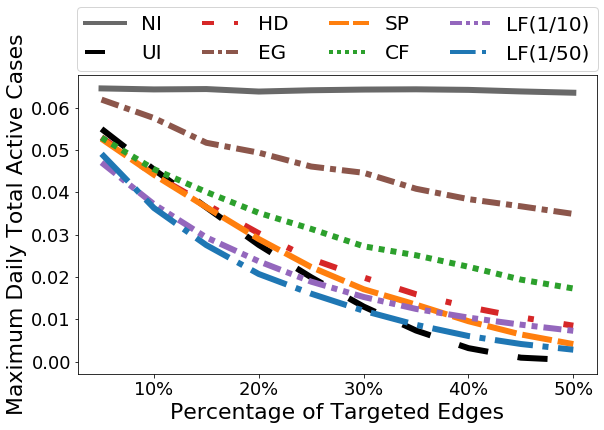

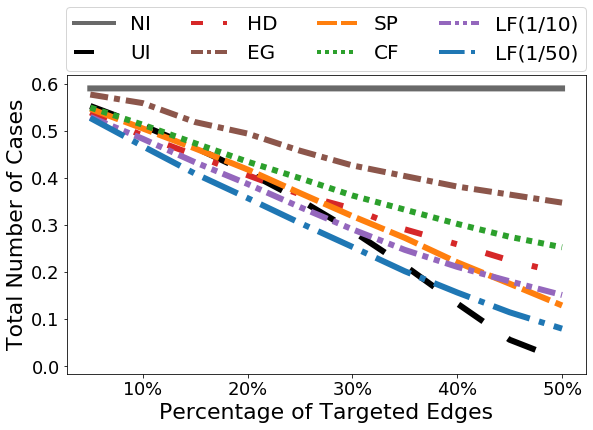

In [38]:
maxCases_ni_mean = np.mean(maxCases_ni/total_population, axis=0)
maxCases_ui_mean = np.mean(maxCases_ui/total_population, axis=0)
maxCases_hd_mean = np.mean(maxCases_hd/total_population, axis=0)
maxCases_eg_mean = np.mean(maxCases_eg/total_population, axis=0)
maxCases_sp_mean = np.mean(maxCases_sp/total_population, axis=0)
maxCases_rw_mean = np.mean(maxCases_rw/total_population, axis=0)
maxCases_lf10_mean = np.mean(maxCases_lf10/total_population, axis=0)
maxCases_lf02_mean = np.mean(maxCases_lf02/total_population, axis=0)
totalCases_ni_mean = np.mean(totalCases_ni/total_population, axis=0)
totalCases_ui_mean = np.mean(totalCases_ui/total_population, axis=0)
totalCases_hd_mean = np.mean(totalCases_hd/total_population, axis=0)
totalCases_eg_mean = np.mean(totalCases_eg/total_population, axis=0)
totalCases_sp_mean = np.mean(totalCases_sp/total_population, axis=0)
totalCases_rw_mean = np.mean(totalCases_rw/total_population, axis=0)
totalCases_lf10_mean = np.mean(totalCases_lf10/total_population, axis=0)
totalCases_lf02_mean = np.mean(totalCases_lf02/total_population, axis=0)

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, maxCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, maxCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, maxCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, maxCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks(size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Maximum Daily Total Active Cases',fontsize=22)
plt.savefig("facebook_epipeak_randinit_R015_delay45.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, totalCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, totalCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, totalCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, totalCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks(size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Total Number of Cases',fontsize=22)
plt.savefig("facebook_episize_randinit_R015_delay45.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

## Scenario 3: $R_0 = 3.5$

#### Verify that $\beta$ is set appropriately

In [39]:
# initial conditions
S_0 = np.zeros(n)
E_0 = np.zeros(n)
I_0 = np.zeros(n)
R_0 = np.zeros(n)
for i in range(n):
    S_0[i] = populations[map_to_original[i+1]] 
for i in sample(range(n),31):
    E_0[i] = 0
    I_0[i] = populations[map_to_original[i+1]] * .001
    S_0[i] = S_0[i] - E_0[i] - I_0[i]
    
ini_cond = np.column_stack((S_0,E_0,I_0,R_0))

# time span
t_end = 200.
t_span = (0.,t_end)

sol = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond, t_span, R_0=3.5, phi=.073)
print(f'This should be around 0.966: {get_total_active_cases(sol)/total_population:.6f}')

This should be around 0.966: 0.966237


### Sample epidemic curves

In [40]:
perc = .25
reduced_weight = .1

In [41]:
A_ui = ((1-(1-reduced_weight)*perc)*nx.adjacency_matrix(G) + sp.sparse.eye(G.number_of_nodes())).tocsc()
A_hd = create_weighted_adjacency_from_degree_dist(G, perc, weight=reduced_weight)
A_eg = create_weighted_adjacency_from_node_betweenness(G, eigenvector_centrality, perc, weight=reduced_weight)
A_sp = create_weighted_adjacency_from_edge_betweenness(G, shortest_path_betweenness, perc, weight=reduced_weight)
A_rw = create_weighted_adjacency_from_edge_betweenness(G, current_flow_betweenness, perc, weight=reduced_weight)
A_lf10 = create_weighted_adjacency_from_edge_betweenness(G, local10_betweenness, perc, weight=reduced_weight)
A_lf02 = create_weighted_adjacency_from_edge_betweenness(G, local02_betweenness, perc, weight=reduced_weight)

#### Predicted epidemic curves: $R_0 = 3.5$, random initialization, no delay, 25% intervention

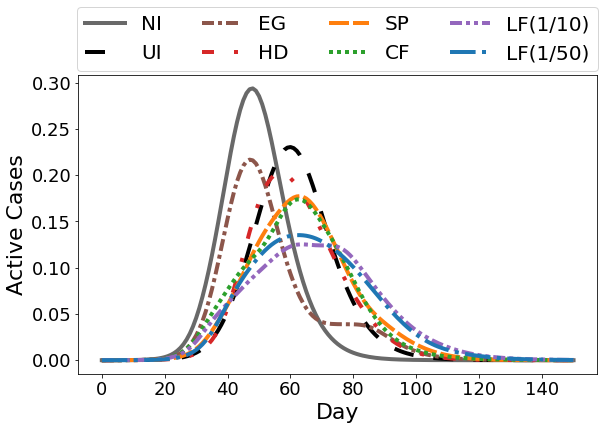

In [42]:
# time span
t_end = 150.
t_span = (0., t_end)

# initial conditions
n = G.number_of_nodes()
S_0 = np.zeros(n)
E_0 = np.zeros(n)
I_0 = np.zeros(n)
R_0 = np.zeros(n)
for i in range(n):
    S_0[i] = populations[map_to_original[i+1]]
for i in sample(range(n),31):
    E_0[i] = 0
    I_0[i] = populations[map_to_original[i+1]] * .001
    S_0[i] = S_0[i] - E_0[i] - I_0[i]

ini_cond = np.column_stack((S_0,E_0,I_0,R_0))

# simulation
sol_ni = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond, t_span, R_0=3.5, phi=.073)
sol_ui = Main.run_network_seir(Main.scipyCSC_to_julia(A_ui), ini_cond, t_span, R_0=3.5, phi=.073)
sol_hd = Main.run_network_seir(Main.scipyCSC_to_julia(A_hd), ini_cond, t_span, R_0=3.5, phi=.073)
sol_eg = Main.run_network_seir(Main.scipyCSC_to_julia(A_eg), ini_cond, t_span, R_0=3.5, phi=.073)
sol_sp = Main.run_network_seir(Main.scipyCSC_to_julia(A_sp), ini_cond, t_span, R_0=3.5, phi=.073)
sol_rw = Main.run_network_seir(Main.scipyCSC_to_julia(A_rw), ini_cond, t_span, R_0=3.5, phi=.073)
sol_lf10 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf10), ini_cond, t_span, R_0=3.5, phi=.073)
sol_lf02 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf02), ini_cond, t_span, R_0=3.5, phi=.073)

# get curves and make plot
sum_s_ni, sum_e_ni, sum_i_ni, sum_r_ni = get_data_for_plotting(sol_ni)
sum_s_ui, sum_e_ui, sum_i_ui, sum_r_ui = get_data_for_plotting(sol_ui)
sum_s_hd, sum_e_hd, sum_i_hd, sum_r_hd = get_data_for_plotting(sol_hd)
sum_s_eg, sum_e_eg, sum_i_eg, sum_r_eg = get_data_for_plotting(sol_eg)
sum_s_sp, sum_e_sp, sum_i_sp, sum_r_sp = get_data_for_plotting(sol_sp)
sum_s_rw, sum_e_rw, sum_i_rw, sum_r_rw = get_data_for_plotting(sol_rw)
sum_s_lf10, sum_e_lf10, sum_i_lf10, sum_r_lf10 = get_data_for_plotting(sol_lf10)
sum_s_lf02, sum_e_lf02, sum_i_lf02, sum_r_lf02 = get_data_for_plotting(sol_lf02)

t_int = np.linspace(0, int(t_end), num=int(t_end)+1)

plt.figure(figsize=(9.3,5.5))
plt.plot(t_int,(sum_e_ni+sum_i_ni)/total_population, label='NI', linestyle='-', color='dimgray', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_ui+sum_i_ui)/total_population, label='UI', linestyle=(0,(5,5)), color='k', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_eg+sum_i_eg)/total_population, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=4)
plt.plot(t_int,(sum_e_hd+sum_i_hd)/total_population, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_sp+sum_i_sp)/total_population, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_rw+sum_i_rw)/total_population, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_lf10+sum_i_lf10)/total_population, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=4)
plt.plot(t_int,(sum_e_lf02+sum_i_lf02)/total_population, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=4)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel('Day', fontsize=22)
plt.ylabel('Active Cases',fontsize=22)
plt.savefig("facebook_curves_randinit_R035.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

#### Predicted epidemic curves: $R_0 = 3.5$, random initialization, delay = 30 days, 25% intervention

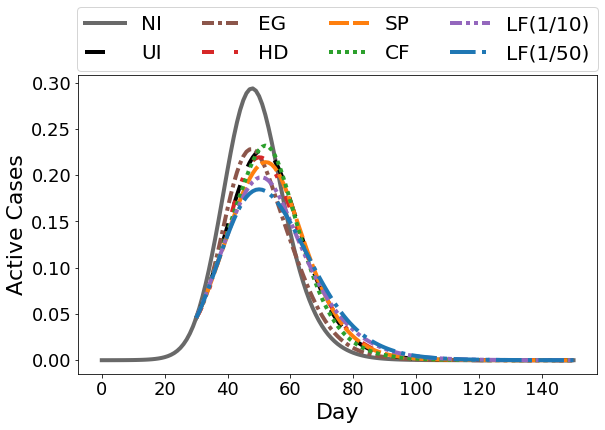

In [43]:
# time span
t_delay = 30.
t_end = 150.
t_span = (t_delay, t_end)

# delayed initial conditions
sol = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond, (0.,t_delay), R_0=3.5, phi=.073) 
ini_cond_delay = sol[-1]

# simulation
sol_ni = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond_delay, t_span, R_0=3.5, phi=.073)
sol_ui = Main.run_network_seir(Main.scipyCSC_to_julia(A_ui), ini_cond_delay, t_span, R_0=3.5, phi=.073)
sol_hd = Main.run_network_seir(Main.scipyCSC_to_julia(A_hd), ini_cond_delay, t_span, R_0=3.5, phi=.073)
sol_eg = Main.run_network_seir(Main.scipyCSC_to_julia(A_eg), ini_cond_delay, t_span, R_0=3.5, phi=.073)
sol_sp = Main.run_network_seir(Main.scipyCSC_to_julia(A_sp), ini_cond_delay, t_span, R_0=3.5, phi=.073)
sol_rw = Main.run_network_seir(Main.scipyCSC_to_julia(A_rw), ini_cond_delay, t_span, R_0=3.5, phi=.073)
sol_lf10 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf10), ini_cond_delay, t_span, R_0=3.5, phi=.073)
sol_lf02 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf02), ini_cond_delay, t_span, R_0=3.5, phi=.073)

# get curves and make plot
sum_s, sum_e, sum_i, sum_r = get_data_for_plotting(sol)
sum_s_ni, sum_e_ni, sum_i_ni, sum_r_ni = get_data_for_plotting(sol_ni)
sum_s_ui, sum_e_ui, sum_i_ui, sum_r_ui = get_data_for_plotting(sol_ui)
sum_s_hd, sum_e_hd, sum_i_hd, sum_r_hd = get_data_for_plotting(sol_hd)
sum_s_eg, sum_e_eg, sum_i_eg, sum_r_eg = get_data_for_plotting(sol_eg)
sum_s_sp, sum_e_sp, sum_i_sp, sum_r_sp = get_data_for_plotting(sol_sp)
sum_s_rw, sum_e_rw, sum_i_rw, sum_r_rw = get_data_for_plotting(sol_rw)
sum_s_lf10, sum_e_lf10, sum_i_lf10, sum_r_lf10 = get_data_for_plotting(sol_lf10)
sum_s_lf02, sum_e_lf02, sum_i_lf02, sum_r_lf02 = get_data_for_plotting(sol_lf02)

t_ini = np.linspace(0, int(t_delay), num=int(t_delay)+1)
t_int = np.linspace(t_delay, int(t_end), num=int(t_end-t_delay)+1)

plt.figure(figsize=(9.3,5.5))
plt.plot(t_ini,(sum_e+sum_i)/total_population, linestyle='-', color='dimgray', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_ni+sum_i_ni)/total_population, label='NI', linestyle='-', color='dimgray', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_ui+sum_i_ui)/total_population, label='UI', linestyle=(0,(5,5)), color='k', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_eg+sum_i_eg)/total_population, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=4)
plt.plot(t_int,(sum_e_hd+sum_i_hd)/total_population, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_sp+sum_i_sp)/total_population, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_rw+sum_i_rw)/total_population, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_lf10+sum_i_lf10)/total_population, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=4)
plt.plot(t_int,(sum_e_lf02+sum_i_lf02)/total_population, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=4)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel('Day', fontsize=22)
plt.ylabel('Active Cases',fontsize=22)
plt.savefig("facebook_curves_randinit_R035_delay30.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

## Simulation for interventions that start on day 0, random initialization, $R_0 = 3.5$

In [44]:
reduced_weight = .1
target_perc = [.05, .1, .15, .2, .25, .3, .35, .4, .45, .5]
num_scenarios = len(target_perc)
num_trials = 50

maxCases_ni = np.zeros((num_trials,num_scenarios))
maxCases_ui = np.zeros((num_trials,num_scenarios))
maxCases_hd = np.zeros((num_trials,num_scenarios))
maxCases_eg = np.zeros((num_trials,num_scenarios))
maxCases_sp = np.zeros((num_trials,num_scenarios))
maxCases_rw = np.zeros((num_trials,num_scenarios))
maxCases_lf10 = np.zeros((num_trials,num_scenarios))
maxCases_lf02 = np.zeros((num_trials,num_scenarios))
totalCases_ni = np.zeros((num_trials,num_scenarios))
totalCases_ui = np.zeros((num_trials,num_scenarios))
totalCases_hd = np.zeros((num_trials,num_scenarios))
totalCases_eg = np.zeros((num_trials,num_scenarios))
totalCases_sp = np.zeros((num_trials,num_scenarios))
totalCases_rw = np.zeros((num_trials,num_scenarios))
totalCases_lf10 = np.zeros((num_trials,num_scenarios))
totalCases_lf02 = np.zeros((num_trials,num_scenarios))

for k in range(num_scenarios):
    
    perc = target_perc[k]
    A_ui = ((1-(1-reduced_weight)*perc)*nx.adjacency_matrix(G) + sp.sparse.eye(G.number_of_nodes())).tocsc()
    A_hd = create_weighted_adjacency_from_degree_dist(G, perc, weight=reduced_weight)
    A_eg = create_weighted_adjacency_from_node_betweenness(G, eigenvector_centrality, perc, weight=reduced_weight)
    A_sp = create_weighted_adjacency_from_edge_betweenness(G, shortest_path_betweenness, perc, weight=reduced_weight)
    A_rw = create_weighted_adjacency_from_edge_betweenness(G, current_flow_betweenness, perc, weight=reduced_weight)
    A_lf10 = create_weighted_adjacency_from_edge_betweenness(G, local10_betweenness, perc, weight=reduced_weight)
    A_lf02 = create_weighted_adjacency_from_edge_betweenness(G, local02_betweenness, perc, weight=reduced_weight)
    
    for trial in range(num_trials):
        
        print(f'perc = {perc:.2f}, trial {trial+1:d} of {num_trials}', end="\r")
    
        S_0 = np.zeros(n)
        E_0 = np.zeros(n)
        I_0 = np.zeros(n)
        R_0 = np.zeros(n)
        for i in range(n):
            S_0[i] = populations[map_to_original[i+1]]
        for i in sample(range(n),31):
            E_0[i] = 0
            I_0[i] = populations[map_to_original[i+1]] * .001
            S_0[i] = S_0[i] - E_0[i] - I_0[i]
        
        ini_cond = np.column_stack((S_0,E_0,I_0,R_0))
        t_span = (0.,500.)
        
        sol_ni = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond, t_span, R_0=3.5, phi=.073)
        sol_ui = Main.run_network_seir(Main.scipyCSC_to_julia(A_ui), ini_cond, t_span, R_0=3.5, phi=.073)
        sol_hd = Main.run_network_seir(Main.scipyCSC_to_julia(A_hd), ini_cond, t_span, R_0=3.5, phi=.073)
        sol_eg = Main.run_network_seir(Main.scipyCSC_to_julia(A_eg), ini_cond, t_span, R_0=3.5, phi=.073)
        sol_sp = Main.run_network_seir(Main.scipyCSC_to_julia(A_sp), ini_cond, t_span, R_0=3.5, phi=.073)
        sol_rw = Main.run_network_seir(Main.scipyCSC_to_julia(A_rw), ini_cond, t_span, R_0=3.5, phi=.073)
        sol_lf10 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf10), ini_cond, t_span, R_0=3.5, phi=.073)
        sol_lf02 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf02), ini_cond, t_span, R_0=3.5, phi=.073) 
        maxCases_ni[trial,k] = get_max_active_cases(sol_ni)
        maxCases_ui[trial,k] = get_max_active_cases(sol_ui)
        maxCases_hd[trial,k] = get_max_active_cases(sol_hd)
        maxCases_eg[trial,k] = get_max_active_cases(sol_eg)
        maxCases_sp[trial,k] = get_max_active_cases(sol_sp)
        maxCases_rw[trial,k] = get_max_active_cases(sol_rw)
        maxCases_lf10[trial,k] = get_max_active_cases(sol_lf10)
        maxCases_lf02[trial,k] = get_max_active_cases(sol_lf02)
        totalCases_ni[trial,k] = get_total_active_cases(sol_ni)
        totalCases_ui[trial,k] = get_total_active_cases(sol_ui)
        totalCases_hd[trial,k] = get_total_active_cases(sol_hd)
        totalCases_eg[trial,k] = get_total_active_cases(sol_eg)
        totalCases_sp[trial,k] = get_total_active_cases(sol_sp)
        totalCases_rw[trial,k] = get_total_active_cases(sol_rw)
        totalCases_lf10[trial,k] = get_total_active_cases(sol_lf10)
        totalCases_lf02[trial,k] = get_total_active_cases(sol_lf02)

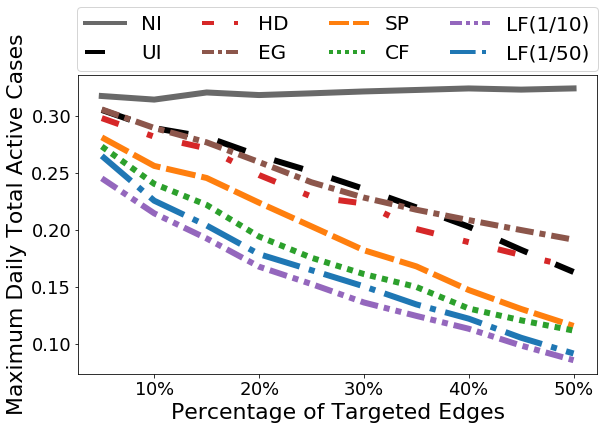

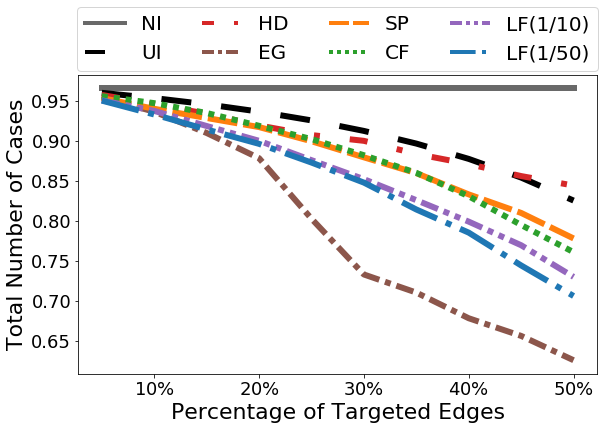

In [45]:
maxCases_ni_mean = np.mean(maxCases_ni/total_population, axis=0)
maxCases_ui_mean = np.mean(maxCases_ui/total_population, axis=0)
maxCases_hd_mean = np.mean(maxCases_hd/total_population, axis=0)
maxCases_eg_mean = np.mean(maxCases_eg/total_population, axis=0)
maxCases_sp_mean = np.mean(maxCases_sp/total_population, axis=0)
maxCases_rw_mean = np.mean(maxCases_rw/total_population, axis=0)
maxCases_lf10_mean = np.mean(maxCases_lf10/total_population, axis=0)
maxCases_lf02_mean = np.mean(maxCases_lf02/total_population, axis=0)
totalCases_ni_mean = np.mean(totalCases_ni/total_population, axis=0)
totalCases_ui_mean = np.mean(totalCases_ui/total_population, axis=0)
totalCases_hd_mean = np.mean(totalCases_hd/total_population, axis=0)
totalCases_eg_mean = np.mean(totalCases_eg/total_population, axis=0)
totalCases_sp_mean = np.mean(totalCases_sp/total_population, axis=0)
totalCases_rw_mean = np.mean(totalCases_rw/total_population, axis=0)
totalCases_lf10_mean = np.mean(totalCases_lf10/total_population, axis=0)
totalCases_lf02_mean = np.mean(totalCases_lf02/total_population, axis=0)

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, maxCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, maxCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, maxCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, maxCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks(size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Maximum Daily Total Active Cases',fontsize=22)
plt.savefig("facebook_epipeak_randinit_R035.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, totalCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, totalCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, totalCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, totalCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks(size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Total Number of Cases',fontsize=22)
plt.savefig("facebook_episize_randinit_R035.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

## Simulation for interventions that start on day 30, random initialization, $R_0 = 3.5$

In [46]:
reduced_weight = .1
target_perc = [.05, .1, .15, .2, .25, .3, .35, .4, .45, .5]
num_scenarios = len(target_perc)
num_trials = 50

maxCases_ni = np.zeros((num_trials,num_scenarios))
maxCases_ui = np.zeros((num_trials,num_scenarios))
maxCases_hd = np.zeros((num_trials,num_scenarios))
maxCases_eg = np.zeros((num_trials,num_scenarios))
maxCases_sp = np.zeros((num_trials,num_scenarios))
maxCases_rw = np.zeros((num_trials,num_scenarios))
maxCases_lf10 = np.zeros((num_trials,num_scenarios))
maxCases_lf02 = np.zeros((num_trials,num_scenarios))
totalCases_ni = np.zeros((num_trials,num_scenarios))
totalCases_ui = np.zeros((num_trials,num_scenarios))
totalCases_hd = np.zeros((num_trials,num_scenarios))
totalCases_eg = np.zeros((num_trials,num_scenarios))
totalCases_sp = np.zeros((num_trials,num_scenarios))
totalCases_rw = np.zeros((num_trials,num_scenarios))
totalCases_lf10 = np.zeros((num_trials,num_scenarios))
totalCases_lf02 = np.zeros((num_trials,num_scenarios))

for k in range(num_scenarios):
    
    perc = target_perc[k]
    A_ui = ((1-(1-reduced_weight)*perc)*nx.adjacency_matrix(G) + sp.sparse.eye(G.number_of_nodes())).tocsc()
    A_hd = create_weighted_adjacency_from_degree_dist(G, perc, weight=reduced_weight)
    A_eg = create_weighted_adjacency_from_node_betweenness(G, eigenvector_centrality, perc, weight=reduced_weight)
    A_sp = create_weighted_adjacency_from_edge_betweenness(G, shortest_path_betweenness, perc, weight=reduced_weight)
    A_rw = create_weighted_adjacency_from_edge_betweenness(G, current_flow_betweenness, perc, weight=reduced_weight)
    A_lf10 = create_weighted_adjacency_from_edge_betweenness(G, local10_betweenness, perc, weight=reduced_weight)
    A_lf02 = create_weighted_adjacency_from_edge_betweenness(G, local02_betweenness, perc, weight=reduced_weight)
    
    for trial in range(num_trials):
        
        print(f'perc = {perc:.2f}, trial {trial+1:d} of {num_trials}', end="\r")
    
        S_0 = np.zeros(n)
        E_0 = np.zeros(n)
        I_0 = np.zeros(n)
        R_0 = np.zeros(n)
        for i in range(n):
            S_0[i] = populations[map_to_original[i+1]]
        for i in sample(range(n),31):
            E_0[i] = 0
            I_0[i] = populations[map_to_original[i+1]] * .001
            S_0[i] = S_0[i] - E_0[i] - I_0[i]
        
        ini_cond = np.column_stack((S_0,E_0,I_0,R_0))
        t_span = (0.,30.)
        sol = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond, t_span, R_0=3.5, phi=.073)
        
        ini_cond = sol[-1]
        t_span = (0.,500.)
        
        sol_ni = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond, t_span, R_0=3.5, phi=.073)
        sol_ui = Main.run_network_seir(Main.scipyCSC_to_julia(A_ui), ini_cond, t_span, R_0=3.5, phi=.073)
        sol_hd = Main.run_network_seir(Main.scipyCSC_to_julia(A_hd), ini_cond, t_span, R_0=3.5, phi=.073)
        sol_eg = Main.run_network_seir(Main.scipyCSC_to_julia(A_eg), ini_cond, t_span, R_0=3.5, phi=.073)
        sol_sp = Main.run_network_seir(Main.scipyCSC_to_julia(A_sp), ini_cond, t_span, R_0=3.5, phi=.073)
        sol_rw = Main.run_network_seir(Main.scipyCSC_to_julia(A_rw), ini_cond, t_span, R_0=3.5, phi=.073)
        sol_lf10 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf10), ini_cond, t_span, R_0=3.5, phi=.073)
        sol_lf02 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf02), ini_cond, t_span, R_0=3.5, phi=.073) 
        maxCases_ni[trial,k] = get_max_active_cases(sol_ni)
        maxCases_ui[trial,k] = get_max_active_cases(sol_ui)
        maxCases_hd[trial,k] = get_max_active_cases(sol_hd)
        maxCases_eg[trial,k] = get_max_active_cases(sol_eg)
        maxCases_sp[trial,k] = get_max_active_cases(sol_sp)
        maxCases_rw[trial,k] = get_max_active_cases(sol_rw)
        maxCases_lf10[trial,k] = get_max_active_cases(sol_lf10)
        maxCases_lf02[trial,k] = get_max_active_cases(sol_lf02)
        totalCases_ni[trial,k] = get_total_active_cases(sol_ni)
        totalCases_ui[trial,k] = get_total_active_cases(sol_ui)
        totalCases_hd[trial,k] = get_total_active_cases(sol_hd)
        totalCases_eg[trial,k] = get_total_active_cases(sol_eg)
        totalCases_sp[trial,k] = get_total_active_cases(sol_sp)
        totalCases_rw[trial,k] = get_total_active_cases(sol_rw)
        totalCases_lf10[trial,k] = get_total_active_cases(sol_lf10)
        totalCases_lf02[trial,k] = get_total_active_cases(sol_lf02)

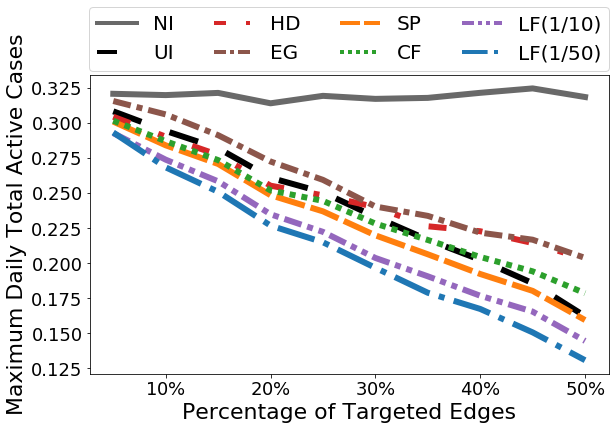

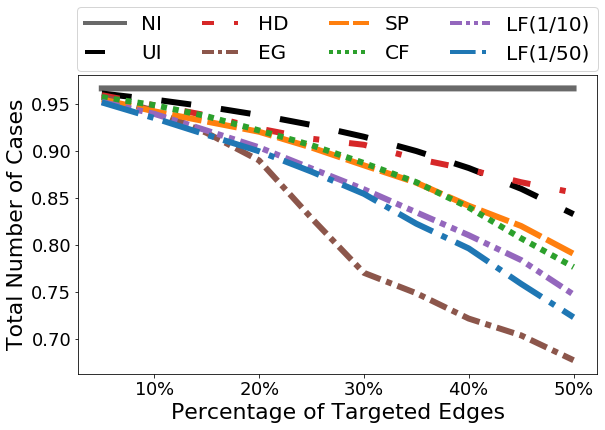

In [47]:
maxCases_ni_mean = np.mean(maxCases_ni/total_population, axis=0)
maxCases_ui_mean = np.mean(maxCases_ui/total_population, axis=0)
maxCases_hd_mean = np.mean(maxCases_hd/total_population, axis=0)
maxCases_eg_mean = np.mean(maxCases_eg/total_population, axis=0)
maxCases_sp_mean = np.mean(maxCases_sp/total_population, axis=0)
maxCases_rw_mean = np.mean(maxCases_rw/total_population, axis=0)
maxCases_lf10_mean = np.mean(maxCases_lf10/total_population, axis=0)
maxCases_lf02_mean = np.mean(maxCases_lf02/total_population, axis=0)
totalCases_ni_mean = np.mean(totalCases_ni/total_population, axis=0)
totalCases_ui_mean = np.mean(totalCases_ui/total_population, axis=0)
totalCases_hd_mean = np.mean(totalCases_hd/total_population, axis=0)
totalCases_eg_mean = np.mean(totalCases_eg/total_population, axis=0)
totalCases_sp_mean = np.mean(totalCases_sp/total_population, axis=0)
totalCases_rw_mean = np.mean(totalCases_rw/total_population, axis=0)
totalCases_lf10_mean = np.mean(totalCases_lf10/total_population, axis=0)
totalCases_lf02_mean = np.mean(totalCases_lf02/total_population, axis=0)

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, maxCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, maxCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, maxCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, maxCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks(size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Maximum Daily Total Active Cases',fontsize=22)
plt.savefig("facebook_epipeak_randinit_R035_delay30.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, totalCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, totalCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, totalCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, totalCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks(size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Total Number of Cases',fontsize=22)
plt.savefig("facebook_episize_randinit_R035_delay30.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

## Scenario 4: $R_0 = 4.5$

#### Verify that $\beta$ is set appropriately

In [48]:
# initial conditions
S_0 = np.zeros(n)
E_0 = np.zeros(n)
I_0 = np.zeros(n)
R_0 = np.zeros(n)
for i in range(n):
    S_0[i] = populations[map_to_original[i+1]] 
for i in sample(range(n),31):
    E_0[i] = 0
    I_0[i] = populations[map_to_original[i+1]] * .001
    S_0[i] = S_0[i] - E_0[i] - I_0[i]
    
ini_cond = np.column_stack((S_0,E_0,I_0,R_0))

# time span
t_end = 200.
t_span = (0.,t_end)

sol = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond, t_span, R_0=4.5, phi=.075)
print(f'This should be around 0.99: {get_total_active_cases(sol)/total_population:.6f}')

This should be around 0.99: 0.989106


### Sample epidemic curves

In [49]:
perc = .25
reduced_weight = .1

In [50]:
A_ui = ((1-(1-reduced_weight)*perc)*nx.adjacency_matrix(G) + sp.sparse.eye(G.number_of_nodes())).tocsc()
A_hd = create_weighted_adjacency_from_degree_dist(G, perc, weight=reduced_weight)
A_eg = create_weighted_adjacency_from_node_betweenness(G, eigenvector_centrality, perc, weight=reduced_weight)
A_sp = create_weighted_adjacency_from_edge_betweenness(G, shortest_path_betweenness, perc, weight=reduced_weight)
A_rw = create_weighted_adjacency_from_edge_betweenness(G, current_flow_betweenness, perc, weight=reduced_weight)
A_lf10 = create_weighted_adjacency_from_edge_betweenness(G, local10_betweenness, perc, weight=reduced_weight)
A_lf02 = create_weighted_adjacency_from_edge_betweenness(G, local02_betweenness, perc, weight=reduced_weight)

#### Predicted epidemic curves: $R_0 = 4.5$, random initialization, no delay, 25% intervention

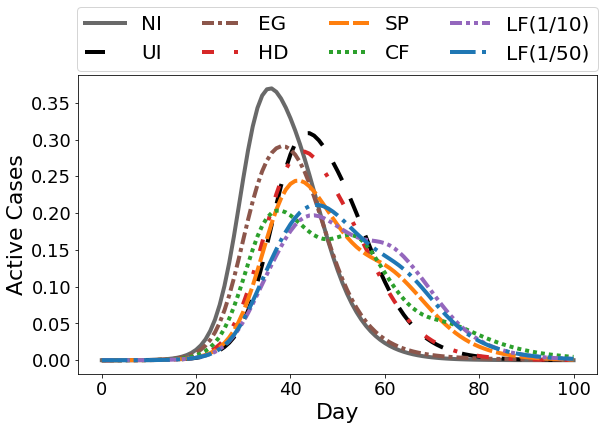

In [51]:
# time span
t_end = 100.
t_span = (0., t_end)

# initial conditions
n = G.number_of_nodes()
S_0 = np.zeros(n)
E_0 = np.zeros(n)
I_0 = np.zeros(n)
R_0 = np.zeros(n)
for i in range(n):
    S_0[i] = populations[map_to_original[i+1]]
for i in sample(range(n),31):
    E_0[i] = 0
    I_0[i] = populations[map_to_original[i+1]] * .001
    S_0[i] = S_0[i] - E_0[i] - I_0[i]

ini_cond = np.column_stack((S_0,E_0,I_0,R_0))

# simulation
sol_ni = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond, t_span, R_0=4.5, phi=.075)
sol_ui = Main.run_network_seir(Main.scipyCSC_to_julia(A_ui), ini_cond, t_span, R_0=4.5, phi=.075)
sol_hd = Main.run_network_seir(Main.scipyCSC_to_julia(A_hd), ini_cond, t_span, R_0=4.5, phi=.075)
sol_eg = Main.run_network_seir(Main.scipyCSC_to_julia(A_eg), ini_cond, t_span, R_0=4.5, phi=.075)
sol_sp = Main.run_network_seir(Main.scipyCSC_to_julia(A_sp), ini_cond, t_span, R_0=4.5, phi=.075)
sol_rw = Main.run_network_seir(Main.scipyCSC_to_julia(A_rw), ini_cond, t_span, R_0=4.5, phi=.075)
sol_lf10 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf10), ini_cond, t_span, R_0=4.5, phi=.075)
sol_lf02 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf02), ini_cond, t_span, R_0=4.5, phi=.075)

# get curves and make plot
sum_s_ni, sum_e_ni, sum_i_ni, sum_r_ni = get_data_for_plotting(sol_ni)
sum_s_ui, sum_e_ui, sum_i_ui, sum_r_ui = get_data_for_plotting(sol_ui)
sum_s_hd, sum_e_hd, sum_i_hd, sum_r_hd = get_data_for_plotting(sol_hd)
sum_s_eg, sum_e_eg, sum_i_eg, sum_r_eg = get_data_for_plotting(sol_eg)
sum_s_sp, sum_e_sp, sum_i_sp, sum_r_sp = get_data_for_plotting(sol_sp)
sum_s_rw, sum_e_rw, sum_i_rw, sum_r_rw = get_data_for_plotting(sol_rw)
sum_s_lf10, sum_e_lf10, sum_i_lf10, sum_r_lf10 = get_data_for_plotting(sol_lf10)
sum_s_lf02, sum_e_lf02, sum_i_lf02, sum_r_lf02 = get_data_for_plotting(sol_lf02)

t_int = np.linspace(0, int(t_end), num=int(t_end)+1)

plt.figure(figsize=(9.3,5.5))
plt.plot(t_int,(sum_e_ni+sum_i_ni)/total_population, label='NI', linestyle='-', color='dimgray', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_ui+sum_i_ui)/total_population, label='UI', linestyle=(0,(5,5)), color='k', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_eg+sum_i_eg)/total_population, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=4)
plt.plot(t_int,(sum_e_hd+sum_i_hd)/total_population, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_sp+sum_i_sp)/total_population, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_rw+sum_i_rw)/total_population, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_lf10+sum_i_lf10)/total_population, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=4)
plt.plot(t_int,(sum_e_lf02+sum_i_lf02)/total_population, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=4)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel('Day', fontsize=22)
plt.ylabel('Active Cases',fontsize=22)
plt.savefig("facebook_curves_randinit_R045.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

#### Predicted epidemic curves: $R_0 = 4.5$, random initialization, delay = 15 days, 25% intervention

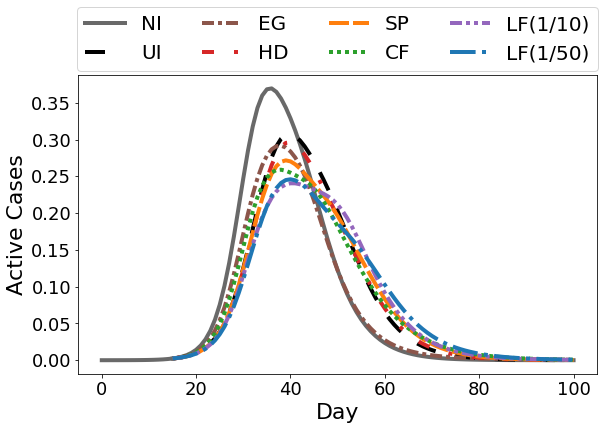

In [52]:
# time span
t_delay = 15.
t_end = 100.
t_span = (t_delay, t_end)

# delayed initial conditions
sol = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond, (0.,t_delay), R_0=4.5, phi=.075) 
ini_cond_delay = sol[-1]

# simulation
sol_ni = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond_delay, t_span, R_0=4.5, phi=.075)
sol_ui = Main.run_network_seir(Main.scipyCSC_to_julia(A_ui), ini_cond_delay, t_span, R_0=4.5, phi=.075)
sol_hd = Main.run_network_seir(Main.scipyCSC_to_julia(A_hd), ini_cond_delay, t_span, R_0=4.5, phi=.075)
sol_eg = Main.run_network_seir(Main.scipyCSC_to_julia(A_eg), ini_cond_delay, t_span, R_0=4.5, phi=.075)
sol_sp = Main.run_network_seir(Main.scipyCSC_to_julia(A_sp), ini_cond_delay, t_span, R_0=4.5, phi=.075)
sol_rw = Main.run_network_seir(Main.scipyCSC_to_julia(A_rw), ini_cond_delay, t_span, R_0=4.5, phi=.075)
sol_lf10 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf10), ini_cond_delay, t_span, R_0=4.5, phi=.075)
sol_lf02 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf02), ini_cond_delay, t_span, R_0=4.5, phi=.075)

# get curves and make plot
sum_s, sum_e, sum_i, sum_r = get_data_for_plotting(sol)
sum_s_ni, sum_e_ni, sum_i_ni, sum_r_ni = get_data_for_plotting(sol_ni)
sum_s_ui, sum_e_ui, sum_i_ui, sum_r_ui = get_data_for_plotting(sol_ui)
sum_s_hd, sum_e_hd, sum_i_hd, sum_r_hd = get_data_for_plotting(sol_hd)
sum_s_eg, sum_e_eg, sum_i_eg, sum_r_eg = get_data_for_plotting(sol_eg)
sum_s_sp, sum_e_sp, sum_i_sp, sum_r_sp = get_data_for_plotting(sol_sp)
sum_s_rw, sum_e_rw, sum_i_rw, sum_r_rw = get_data_for_plotting(sol_rw)
sum_s_lf10, sum_e_lf10, sum_i_lf10, sum_r_lf10 = get_data_for_plotting(sol_lf10)
sum_s_lf02, sum_e_lf02, sum_i_lf02, sum_r_lf02 = get_data_for_plotting(sol_lf02)

t_ini = np.linspace(0, int(t_delay), num=int(t_delay)+1)
t_int = np.linspace(t_delay, int(t_end), num=int(t_end-t_delay)+1)

plt.figure(figsize=(9.3,5.5))
plt.plot(t_ini,(sum_e+sum_i)/total_population, linestyle='-', color='dimgray', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_ni+sum_i_ni)/total_population, label='NI', linestyle='-', color='dimgray', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_ui+sum_i_ui)/total_population, label='UI', linestyle=(0,(5,5)), color='k', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_eg+sum_i_eg)/total_population, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=4)
plt.plot(t_int,(sum_e_hd+sum_i_hd)/total_population, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_sp+sum_i_sp)/total_population, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_rw+sum_i_rw)/total_population, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=4, alpha=1)
plt.plot(t_int,(sum_e_lf10+sum_i_lf10)/total_population, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=4)
plt.plot(t_int,(sum_e_lf02+sum_i_lf02)/total_population, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=4)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel('Day', fontsize=22)
plt.ylabel('Active Cases',fontsize=22)
plt.savefig("facebook_curves_randinit_R045_delay15.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

## Simulation for interventions that start on day 0, random initialization, $R_0 = 4.5$

In [53]:
reduced_weight = .1
target_perc = [.05, .1, .15, .2, .25, .3, .35, .4, .45, .5]
num_scenarios = len(target_perc)
num_trials = 50

maxCases_ni = np.zeros((num_trials,num_scenarios))
maxCases_ui = np.zeros((num_trials,num_scenarios))
maxCases_hd = np.zeros((num_trials,num_scenarios))
maxCases_eg = np.zeros((num_trials,num_scenarios))
maxCases_sp = np.zeros((num_trials,num_scenarios))
maxCases_rw = np.zeros((num_trials,num_scenarios))
maxCases_lf10 = np.zeros((num_trials,num_scenarios))
maxCases_lf02 = np.zeros((num_trials,num_scenarios))
totalCases_ni = np.zeros((num_trials,num_scenarios))
totalCases_ui = np.zeros((num_trials,num_scenarios))
totalCases_hd = np.zeros((num_trials,num_scenarios))
totalCases_eg = np.zeros((num_trials,num_scenarios))
totalCases_sp = np.zeros((num_trials,num_scenarios))
totalCases_rw = np.zeros((num_trials,num_scenarios))
totalCases_lf10 = np.zeros((num_trials,num_scenarios))
totalCases_lf02 = np.zeros((num_trials,num_scenarios))

for k in range(num_scenarios):
    
    perc = target_perc[k]
    A_ui = ((1-(1-reduced_weight)*perc)*nx.adjacency_matrix(G) + sp.sparse.eye(G.number_of_nodes())).tocsc()
    A_hd = create_weighted_adjacency_from_degree_dist(G, perc, weight=reduced_weight)
    A_eg = create_weighted_adjacency_from_node_betweenness(G, eigenvector_centrality, perc, weight=reduced_weight)
    A_sp = create_weighted_adjacency_from_edge_betweenness(G, shortest_path_betweenness, perc, weight=reduced_weight)
    A_rw = create_weighted_adjacency_from_edge_betweenness(G, current_flow_betweenness, perc, weight=reduced_weight)
    A_lf10 = create_weighted_adjacency_from_edge_betweenness(G, local10_betweenness, perc, weight=reduced_weight)
    A_lf02 = create_weighted_adjacency_from_edge_betweenness(G, local02_betweenness, perc, weight=reduced_weight)
    
    for trial in range(num_trials):
        
        print(f'perc = {perc:.2f}, trial {trial+1:d} of {num_trials}', end="\r")
    
        S_0 = np.zeros(n)
        E_0 = np.zeros(n)
        I_0 = np.zeros(n)
        R_0 = np.zeros(n)
        for i in range(n):
            S_0[i] = populations[map_to_original[i+1]]
        for i in sample(range(n),31):
            E_0[i] = 0
            I_0[i] = populations[map_to_original[i+1]] * .001
            S_0[i] = S_0[i] - E_0[i] - I_0[i]
        
        ini_cond = np.column_stack((S_0,E_0,I_0,R_0))
        t_span = (0.,500.)
        
        sol_ni = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond, t_span, R_0=4.5, phi=.075)
        sol_ui = Main.run_network_seir(Main.scipyCSC_to_julia(A_ui), ini_cond, t_span, R_0=4.5, phi=.075)
        sol_hd = Main.run_network_seir(Main.scipyCSC_to_julia(A_hd), ini_cond, t_span, R_0=4.5, phi=.075)
        sol_eg = Main.run_network_seir(Main.scipyCSC_to_julia(A_eg), ini_cond, t_span, R_0=4.5, phi=.075)
        sol_sp = Main.run_network_seir(Main.scipyCSC_to_julia(A_sp), ini_cond, t_span, R_0=4.5, phi=.075)
        sol_rw = Main.run_network_seir(Main.scipyCSC_to_julia(A_rw), ini_cond, t_span, R_0=4.5, phi=.075)
        sol_lf10 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf10), ini_cond, t_span, R_0=4.5, phi=.075)
        sol_lf02 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf02), ini_cond, t_span, R_0=4.5, phi=.075) 
        maxCases_ni[trial,k] = get_max_active_cases(sol_ni)
        maxCases_ui[trial,k] = get_max_active_cases(sol_ui)
        maxCases_hd[trial,k] = get_max_active_cases(sol_hd)
        maxCases_eg[trial,k] = get_max_active_cases(sol_eg)
        maxCases_sp[trial,k] = get_max_active_cases(sol_sp)
        maxCases_rw[trial,k] = get_max_active_cases(sol_rw)
        maxCases_lf10[trial,k] = get_max_active_cases(sol_lf10)
        maxCases_lf02[trial,k] = get_max_active_cases(sol_lf02)
        totalCases_ni[trial,k] = get_total_active_cases(sol_ni)
        totalCases_ui[trial,k] = get_total_active_cases(sol_ui)
        totalCases_hd[trial,k] = get_total_active_cases(sol_hd)
        totalCases_eg[trial,k] = get_total_active_cases(sol_eg)
        totalCases_sp[trial,k] = get_total_active_cases(sol_sp)
        totalCases_rw[trial,k] = get_total_active_cases(sol_rw)
        totalCases_lf10[trial,k] = get_total_active_cases(sol_lf10)
        totalCases_lf02[trial,k] = get_total_active_cases(sol_lf02)

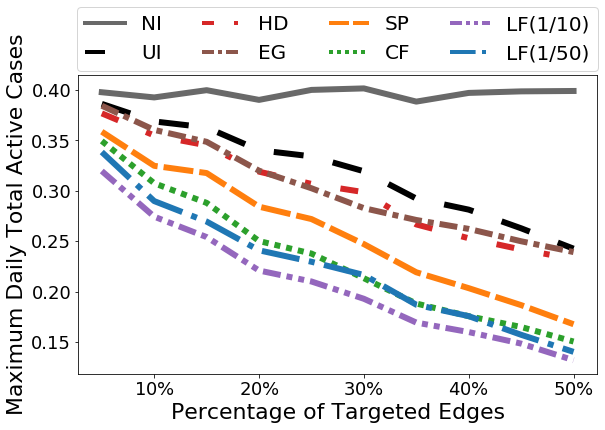

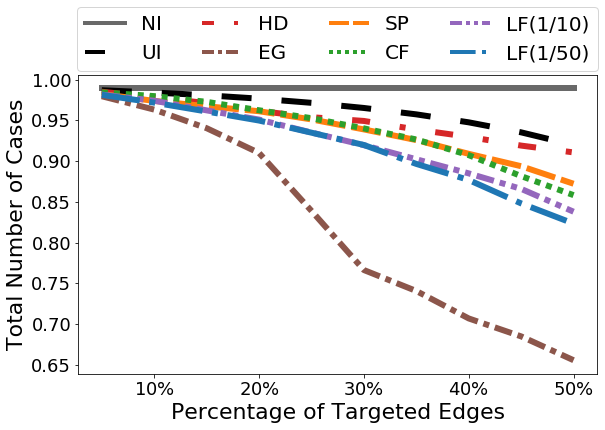

In [54]:
maxCases_ni_mean = np.mean(maxCases_ni/total_population, axis=0)
maxCases_ui_mean = np.mean(maxCases_ui/total_population, axis=0)
maxCases_hd_mean = np.mean(maxCases_hd/total_population, axis=0)
maxCases_eg_mean = np.mean(maxCases_eg/total_population, axis=0)
maxCases_sp_mean = np.mean(maxCases_sp/total_population, axis=0)
maxCases_rw_mean = np.mean(maxCases_rw/total_population, axis=0)
maxCases_lf10_mean = np.mean(maxCases_lf10/total_population, axis=0)
maxCases_lf02_mean = np.mean(maxCases_lf02/total_population, axis=0)
totalCases_ni_mean = np.mean(totalCases_ni/total_population, axis=0)
totalCases_ui_mean = np.mean(totalCases_ui/total_population, axis=0)
totalCases_hd_mean = np.mean(totalCases_hd/total_population, axis=0)
totalCases_eg_mean = np.mean(totalCases_eg/total_population, axis=0)
totalCases_sp_mean = np.mean(totalCases_sp/total_population, axis=0)
totalCases_rw_mean = np.mean(totalCases_rw/total_population, axis=0)
totalCases_lf10_mean = np.mean(totalCases_lf10/total_population, axis=0)
totalCases_lf02_mean = np.mean(totalCases_lf02/total_population, axis=0)

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, maxCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, maxCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, maxCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, maxCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks(size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Maximum Daily Total Active Cases',fontsize=22)
plt.savefig("facebook_epipeak_randinit_R045.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, totalCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, totalCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, totalCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, totalCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks(size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Total Number of Cases',fontsize=22)
plt.savefig("facebook_episize_randinit_R045.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

## Simulation for interventions that start on day 15, random initialization, $R_0 = 4.5$

In [55]:
reduced_weight = .1
target_perc = [.05, .1, .15, .2, .25, .3, .35, .4, .45, .5]
num_scenarios = len(target_perc)
num_trials = 50

maxCases_ni = np.zeros((num_trials,num_scenarios))
maxCases_ui = np.zeros((num_trials,num_scenarios))
maxCases_hd = np.zeros((num_trials,num_scenarios))
maxCases_eg = np.zeros((num_trials,num_scenarios))
maxCases_sp = np.zeros((num_trials,num_scenarios))
maxCases_rw = np.zeros((num_trials,num_scenarios))
maxCases_lf10 = np.zeros((num_trials,num_scenarios))
maxCases_lf02 = np.zeros((num_trials,num_scenarios))
totalCases_ni = np.zeros((num_trials,num_scenarios))
totalCases_ui = np.zeros((num_trials,num_scenarios))
totalCases_hd = np.zeros((num_trials,num_scenarios))
totalCases_eg = np.zeros((num_trials,num_scenarios))
totalCases_sp = np.zeros((num_trials,num_scenarios))
totalCases_rw = np.zeros((num_trials,num_scenarios))
totalCases_lf10 = np.zeros((num_trials,num_scenarios))
totalCases_lf02 = np.zeros((num_trials,num_scenarios))

for k in range(num_scenarios):
    
    perc = target_perc[k]
    A_ui = ((1-(1-reduced_weight)*perc)*nx.adjacency_matrix(G) + sp.sparse.eye(G.number_of_nodes())).tocsc()
    A_hd = create_weighted_adjacency_from_degree_dist(G, perc, weight=reduced_weight)
    A_eg = create_weighted_adjacency_from_node_betweenness(G, eigenvector_centrality, perc, weight=reduced_weight)
    A_sp = create_weighted_adjacency_from_edge_betweenness(G, shortest_path_betweenness, perc, weight=reduced_weight)
    A_rw = create_weighted_adjacency_from_edge_betweenness(G, current_flow_betweenness, perc, weight=reduced_weight)
    A_lf10 = create_weighted_adjacency_from_edge_betweenness(G, local10_betweenness, perc, weight=reduced_weight)
    A_lf02 = create_weighted_adjacency_from_edge_betweenness(G, local02_betweenness, perc, weight=reduced_weight)
    
    for trial in range(num_trials):
        
        print(f'perc = {perc:.2f}, trial {trial+1:d} of {num_trials}', end="\r")
    
        S_0 = np.zeros(n)
        E_0 = np.zeros(n)
        I_0 = np.zeros(n)
        R_0 = np.zeros(n)
        for i in range(n):
            S_0[i] = populations[map_to_original[i+1]]
        for i in sample(range(n),31):
            E_0[i] = 0
            I_0[i] = populations[map_to_original[i+1]] * .001
            S_0[i] = S_0[i] - E_0[i] - I_0[i]
        
        ini_cond = np.column_stack((S_0,E_0,I_0,R_0))
        t_span = (0.,15.)
        sol = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond, t_span, R_0=4.5, phi=.075)
        
        ini_cond = sol[-1]
        t_span = (0.,500.)
        
        sol_ni = Main.run_network_seir(Main.scipyCSC_to_julia(A), ini_cond, t_span, R_0=4.5, phi=.075)
        sol_ui = Main.run_network_seir(Main.scipyCSC_to_julia(A_ui), ini_cond, t_span, R_0=4.5, phi=.075)
        sol_hd = Main.run_network_seir(Main.scipyCSC_to_julia(A_hd), ini_cond, t_span, R_0=4.5, phi=.075)
        sol_eg = Main.run_network_seir(Main.scipyCSC_to_julia(A_eg), ini_cond, t_span, R_0=4.5, phi=.075)
        sol_sp = Main.run_network_seir(Main.scipyCSC_to_julia(A_sp), ini_cond, t_span, R_0=4.5, phi=.075)
        sol_rw = Main.run_network_seir(Main.scipyCSC_to_julia(A_rw), ini_cond, t_span, R_0=4.5, phi=.075)
        sol_lf10 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf10), ini_cond, t_span, R_0=4.5, phi=.075)
        sol_lf02 = Main.run_network_seir(Main.scipyCSC_to_julia(A_lf02), ini_cond, t_span, R_0=4.5, phi=.075) 
        maxCases_ni[trial,k] = get_max_active_cases(sol_ni)
        maxCases_ui[trial,k] = get_max_active_cases(sol_ui)
        maxCases_hd[trial,k] = get_max_active_cases(sol_hd)
        maxCases_eg[trial,k] = get_max_active_cases(sol_eg)
        maxCases_sp[trial,k] = get_max_active_cases(sol_sp)
        maxCases_rw[trial,k] = get_max_active_cases(sol_rw)
        maxCases_lf10[trial,k] = get_max_active_cases(sol_lf10)
        maxCases_lf02[trial,k] = get_max_active_cases(sol_lf02)
        totalCases_ni[trial,k] = get_total_active_cases(sol_ni)
        totalCases_ui[trial,k] = get_total_active_cases(sol_ui)
        totalCases_hd[trial,k] = get_total_active_cases(sol_hd)
        totalCases_eg[trial,k] = get_total_active_cases(sol_eg)
        totalCases_sp[trial,k] = get_total_active_cases(sol_sp)
        totalCases_rw[trial,k] = get_total_active_cases(sol_rw)
        totalCases_lf10[trial,k] = get_total_active_cases(sol_lf10)
        totalCases_lf02[trial,k] = get_total_active_cases(sol_lf02)

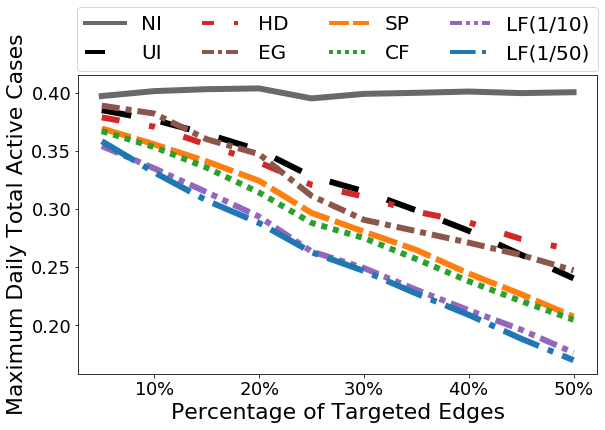

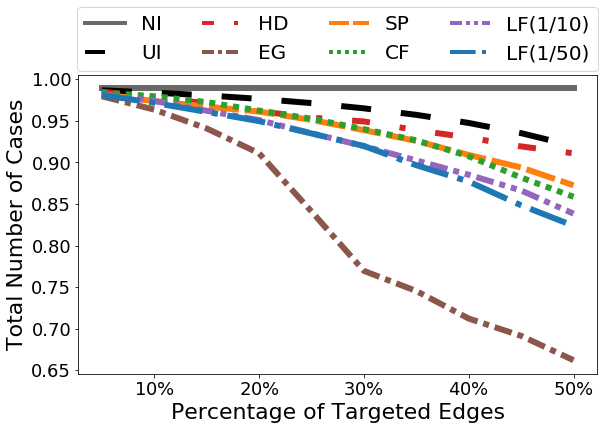

In [56]:
maxCases_ni_mean = np.mean(maxCases_ni/total_population, axis=0)
maxCases_ui_mean = np.mean(maxCases_ui/total_population, axis=0)
maxCases_hd_mean = np.mean(maxCases_hd/total_population, axis=0)
maxCases_eg_mean = np.mean(maxCases_eg/total_population, axis=0)
maxCases_sp_mean = np.mean(maxCases_sp/total_population, axis=0)
maxCases_rw_mean = np.mean(maxCases_rw/total_population, axis=0)
maxCases_lf10_mean = np.mean(maxCases_lf10/total_population, axis=0)
maxCases_lf02_mean = np.mean(maxCases_lf02/total_population, axis=0)
totalCases_ni_mean = np.mean(totalCases_ni/total_population, axis=0)
totalCases_ui_mean = np.mean(totalCases_ui/total_population, axis=0)
totalCases_hd_mean = np.mean(totalCases_hd/total_population, axis=0)
totalCases_eg_mean = np.mean(totalCases_eg/total_population, axis=0)
totalCases_sp_mean = np.mean(totalCases_sp/total_population, axis=0)
totalCases_rw_mean = np.mean(totalCases_rw/total_population, axis=0)
totalCases_lf10_mean = np.mean(totalCases_lf10/total_population, axis=0)
totalCases_lf02_mean = np.mean(totalCases_lf02/total_population, axis=0)

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, maxCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, maxCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, maxCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, maxCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks(size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Maximum Daily Total Active Cases',fontsize=22)
plt.savefig("facebook_epipeak_randinit_R045_delay15.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, totalCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, totalCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, totalCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, totalCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks(size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Total Number of Cases',fontsize=22)
plt.savefig("facebook_episize_randinit_R045_delay15.png", bbox_inches='tight', format='png', dpi=400)
plt.show()